<a id="lib"></a>
<h3 name='libraries'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Import Necessary Libraries
            </span>   
        </font>    
</h3>

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from scipy.stats import ttest_rel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import influence_plot

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import shap

import pydotplus as pdot
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import numpy as np
import pandas as pd
from dateutil import parser

# Setting pandas print option to Limit decimal places to 4
np.set_printoptions(precision=4, linewidth=100)

<a id="roc"></a>
<h5 name='roc'>   
      <font color = black >
            <span style='font-family:Georgia'>
            Defining the ROC Curve & Confusion Matrix Functions
            </span>   
        </font>    
</h5>

In [2]:
def draw_roc( actual, probs ):
    fpr, \
    tpr, \
    thresholds = metrics.roc_curve( actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(8, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sn.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

<a id="mod1"></a>
<h2 name='model1'>   
      <font color = blue >
            <span style='font-family:Georgia'>
            Model 1: Relation between Churn and Price
            </span>   
        </font>    
</h2>

<a id="load"></a>
<h3 name='load'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Loading the Data
            </span>   
        </font>    
</h3>

In [3]:
churn_df = pd.read_csv( "Flight_data.csv" )
churn_df = churn_df.drop(['delay_minutes', 'customerID'], axis=1)
churn_df.head()

departure_city    arrival_city departure_date departure_time  \
0          Wilsonstad  Lake Johnmouth     02-05-2023       20:11:00   
1           New Brent      Port Wanda     21-04-2023       00:10:00   
2  South Samanthaberg  Lake Meganside     12-05-2023       15:16:00   
3      Lake Gracefurt       Jamesberg     13-06-2023       20:53:00   
4         Owenborough     Kelleymouth     15-05-2023       23:06:00   

    time_category  day  month  year day_of_the_week  flight_duration  ...  \
0           Night    2      5  2023         Tuesday          1.27581  ...   
1  Post Mid Night   21      4  2023          Friday          1.27581  ...   
2       Afternoon   12      5  2023          Friday          0.72111  ...   
3           Night   13      6  2023         Tuesday          0.94299  ...   
4           Night   15      5  2023          Monday          0.38829  ...   

  flyer_status    route ticket_price competitor_price  demand_factor  \
0         Gold  MEL-BNE   370.638128       382.947396      -0.932755   
1     Platinum  BNE-SYD   114.529016       394.583641      -1.005569   
2     Platinum  MEL-BNE   164.468018       479.832444       1.761384   
3         Gold  BNE-SYD   318.903167       286.301632      -0.520139   
4       Silver  BNE-SYD   389.971051       407.463316      -0.665768   

   origin_code  destination_code profitability_factor loyalty_points  churned  
0          MEL               LHR             0.632226           4245     True  
1          MEL               SIN             1.265026            833     True  
2          MEL               LAX             1.141651           2568     True  
3          MEL               LAX             1.129291            284    False  
4          BNE               SIN             1.218239           2805     True  

[5 rows x 22 columns]

<a id="desc"></a>
<h3 name='desc'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Descriptive Analytics
            </span>   
        </font>    
</h3>

In [4]:
# Data Understanding
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   departure_city        100 non-null    object 
 1   arrival_city          100 non-null    object 
 2   departure_date        100 non-null    object 
 3   departure_time        100 non-null    object 
 4   time_category         100 non-null    object 
 5   day                   100 non-null    int64  
 6   month                 100 non-null    int64  
 7   year                  100 non-null    int64  
 8   day_of_the_week       100 non-null    object 
 9   flight_duration       100 non-null    float64
 10  customerName          100 non-null    object 
 11  booking_class         100 non-null    object 
 12  flyer_status          100 non-null    object 
 13  route                 100 non-null    object 
 14  ticket_price          100 non-null    float64
 15  competitor_price      10

In [5]:
# Summary Statistics
churn_df.describe()

day       month    year  flight_duration  ticket_price  \
count  100.000000  100.000000   100.0       100.000000    100.000000   
mean    14.670000    5.130000  2023.0         0.875317    303.337169   
std      9.735964    0.719919     0.0         0.485986    119.160993   
min      1.000000    4.000000  2023.0         0.166410    114.529016   
25%      5.000000    5.000000  2023.0         0.388290    191.771980   
50%     15.000000    5.000000  2023.0         0.942990    297.944962   
75%     23.250000    6.000000  2023.0         1.275810    412.563311   
max     31.000000    6.000000  2023.0         1.497691    498.549369   

       competitor_price  demand_factor  profitability_factor  loyalty_points  
count        100.000000   1.000000e+02            100.000000      100.000000  
mean         292.867827   2.000000e-11              1.031524     2390.420000  
std          113.418380   1.005038e+00              0.273866     1522.693017  
min           93.418926  -1.660900e+00              0.515533       45.000000  
25%          208.760294  -8.356685e-01              0.869040     1063.500000  
50%          278.177555  -5.897980e-02              1.033363     2178.000000  
75%          390.125772   6.570301e-01              1.221841     3818.500000  
max          479.832444   1.979828e+00              1.492505     4950.000000

In [6]:
# Identifying Unique Values
non_numeric_columns = churn_df.select_dtypes(exclude=['number']).columns

# Display unique values and counts for each non-numeric column
for column in non_numeric_columns:
    unique_values_counts = churn_df[column].value_counts()
    print(f"Unique values for '{column}':")
    print(unique_values_counts)
    print("\n" + "="*50 + "\n")  # Separating each column's output for clarity


Unique values for 'departure_city':
departure_city
Wilsonstad        1
North Selena      1
Josephview        1
Coryton           1
Port Cory         1
                 ..
North Lorifurt    1
New Sarashire     1
Gregorystad       1
Port Edgar        1
Butlerside        1
Name: count, Length: 100, dtype: int64


Unique values for 'arrival_city':
arrival_city
Port Robert         2
Lake Johnmouth      1
Katherineburgh      1
Hillport            1
Russellberg         1
                   ..
Johnsontown         1
West Graceside      1
Hamiltonburgh       1
Aliciaview          1
East Morganburgh    1
Name: count, Length: 99, dtype: int64


Unique values for 'departure_date':
departure_date
03-06-2023    5
15-05-2023    4
01-06-2023    4
26-04-2023    4
02-06-2023    4
07-06-2023    4
31-05-2023    3
18-04-2023    3
25-05-2023    3
01-05-2023    3
21-05-2023    3
04-06-2023    3
05-06-2023    3
26-05-2023    3
23-04-2023    3
21-04-2023    2
06-05-2023    2
17-05-2023    2
29-04-2023    2
28-0

<a id="eda"></a>
<h3 name='eda'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Exploratory Data Analytics
            </span>   
        </font>    
</h3>

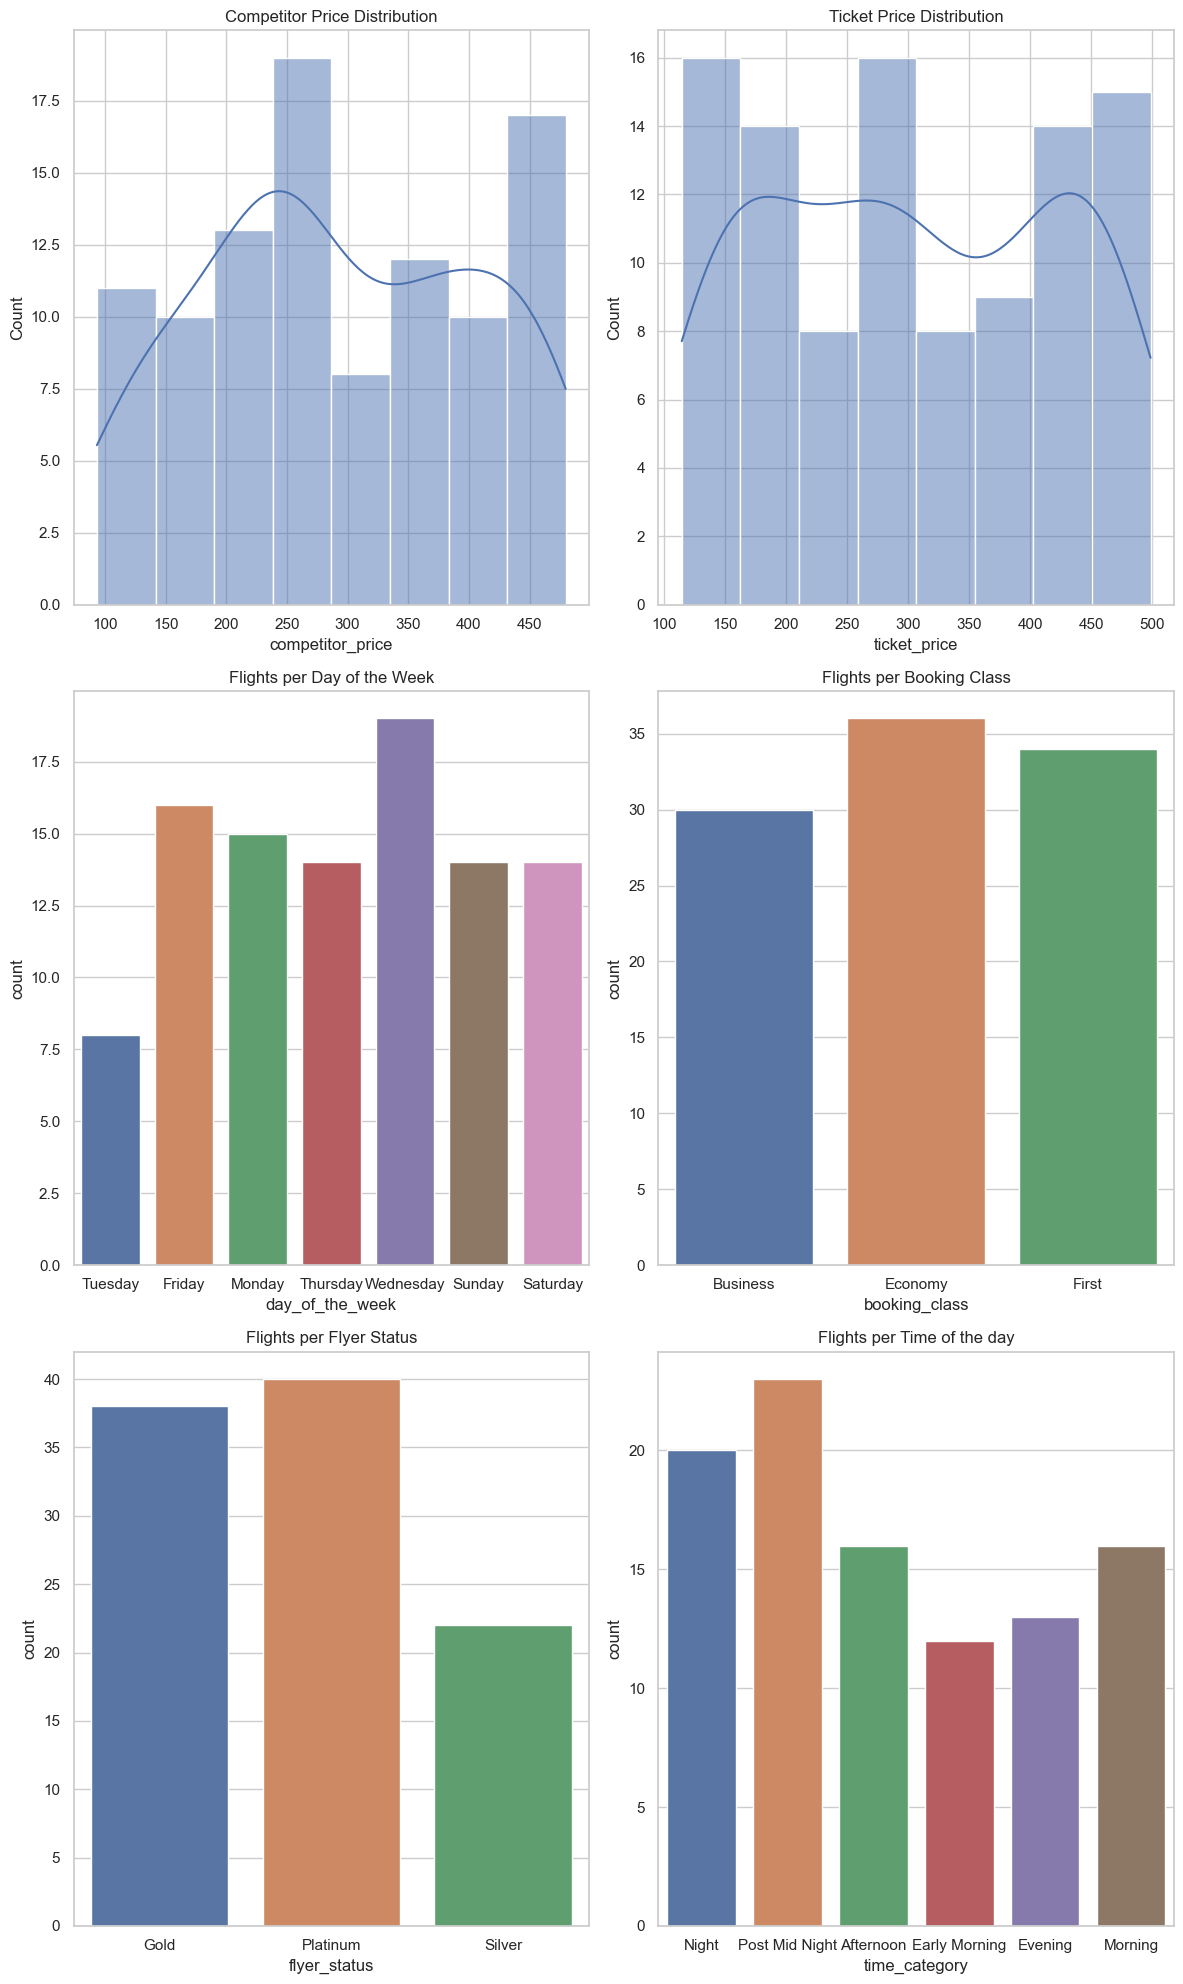

In [7]:
# Set the style for Seaborn
sn.set(style="whitegrid")

# Data Distribution Visualization
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 20))

# Competitor Price Distribution
sn.histplot(data=churn_df, x='competitor_price', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Competitor Price Distribution')

# Ticket Price Distribution
sn.histplot(data=churn_df, x='ticket_price', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Ticket Price Distribution')

# Flights per Day of the Week
sn.countplot(data=churn_df, x='day_of_the_week', ax=axes[1, 0])
axes[1, 0].set_title('Flights per Day of the Week')

# Flights per Booking Class
sn.countplot(data=churn_df, x='booking_class', ax=axes[1, 1])
axes[1, 1].set_title('Flights per Booking Class')

# Flights per Flyer Status
sn.countplot(data=churn_df, x='flyer_status', ax=axes[2, 0])
axes[2, 0].set_title('Flights per Flyer Status')

# Flights per Time of the day
sn.countplot(data=churn_df, x='time_category', ax=axes[2, 1])
axes[2, 1].set_title('Flights per Time of the day')

plt.tight_layout()
plt.show()


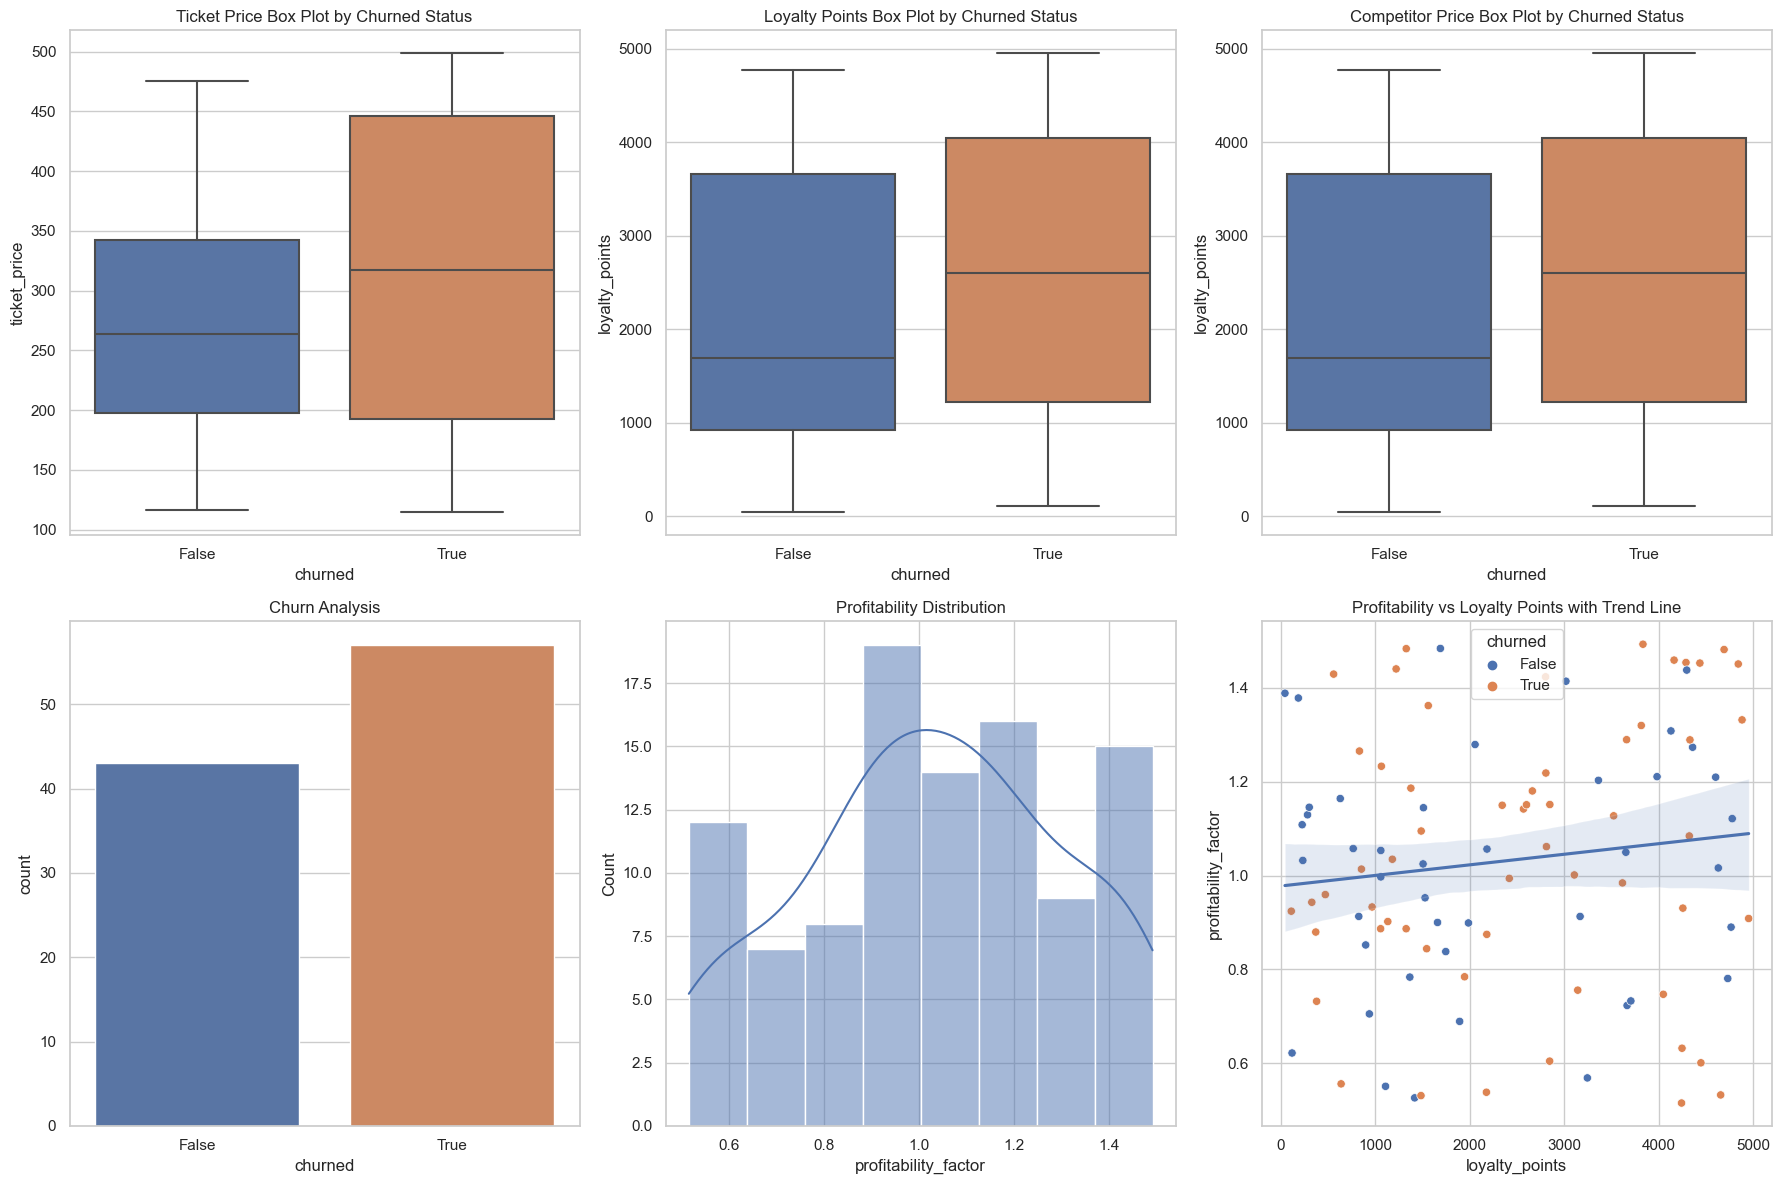

In [8]:
# Set the style for Seaborn
sn.set(style="whitegrid")

# Create a 2x3 grid layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Box Plot for Churn and Ticket Price
sn.boxplot(x='churned', y='ticket_price', data=churn_df, ax=axes[0, 0])
axes[0, 0].set_title('Ticket Price Box Plot by Churned Status')

# Box Plot for Churn and Loyalty Points
sn.boxplot(x='churned', y='loyalty_points', data=churn_df, ax=axes[0, 1])
axes[0, 1].set_title('Loyalty Points Box Plot by Churned Status')

# Box Plot for Churn and Competitor Price
sn.boxplot(x='churned', y='loyalty_points', data=churn_df, ax=axes[0, 2])
axes[0, 2].set_title('Competitor Price Box Plot by Churned Status')

# Customer Analysis
sn.countplot(x='churned', data=churn_df, ax=axes[1, 0])
axes[1, 0].set_title('Churn Analysis')

# Profitability Distribution
sn.histplot(data=churn_df, x='profitability_factor', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Profitability Distribution')

# Profitability vs Loyalty Points with Trend Line
sn.scatterplot(x='loyalty_points', y='profitability_factor', hue='churned', data=churn_df, ax=axes[1, 2])
axes[1, 2].set_title('Profitability vs Loyalty Points with Trend Line')
sn.regplot(x='loyalty_points', y='profitability_factor', data=churn_df, ax=axes[1, 2], scatter=False)

# Adjust layout
plt.tight_layout()
plt.show()


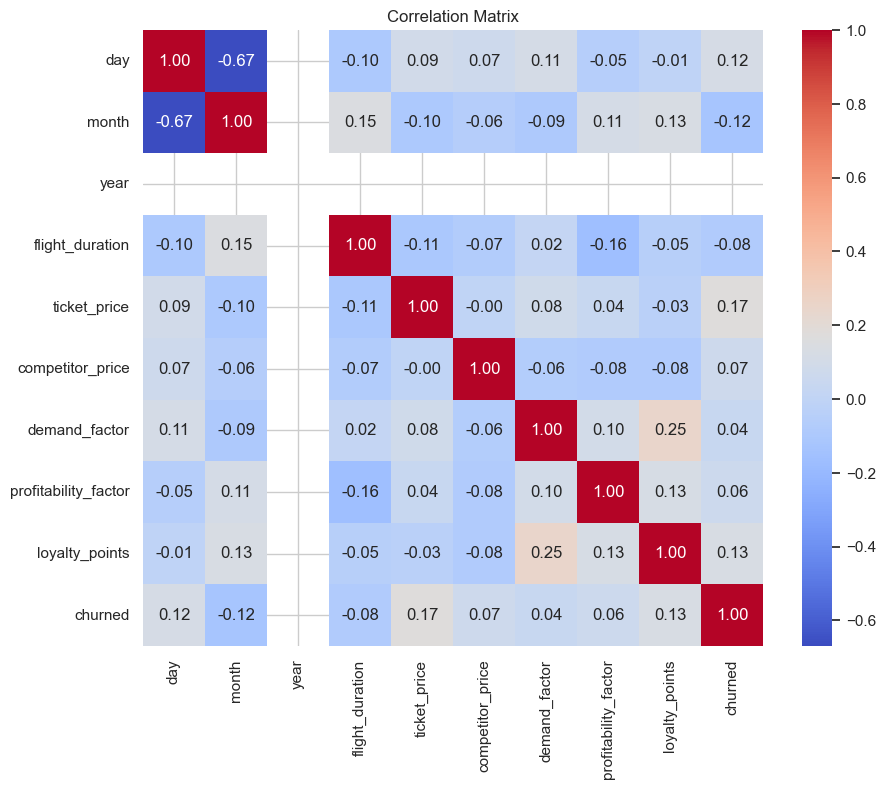

In [9]:
# Creating a Correlation Matrix
churn_df['churned'] = churn_df['churned'].astype(int)

# Select only numeric columns
numeric_columns = churn_df.select_dtypes(include=['number'])

# Build correlation matrix
correlation_matrix_numeric = numeric_columns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with Seaborn
sn.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

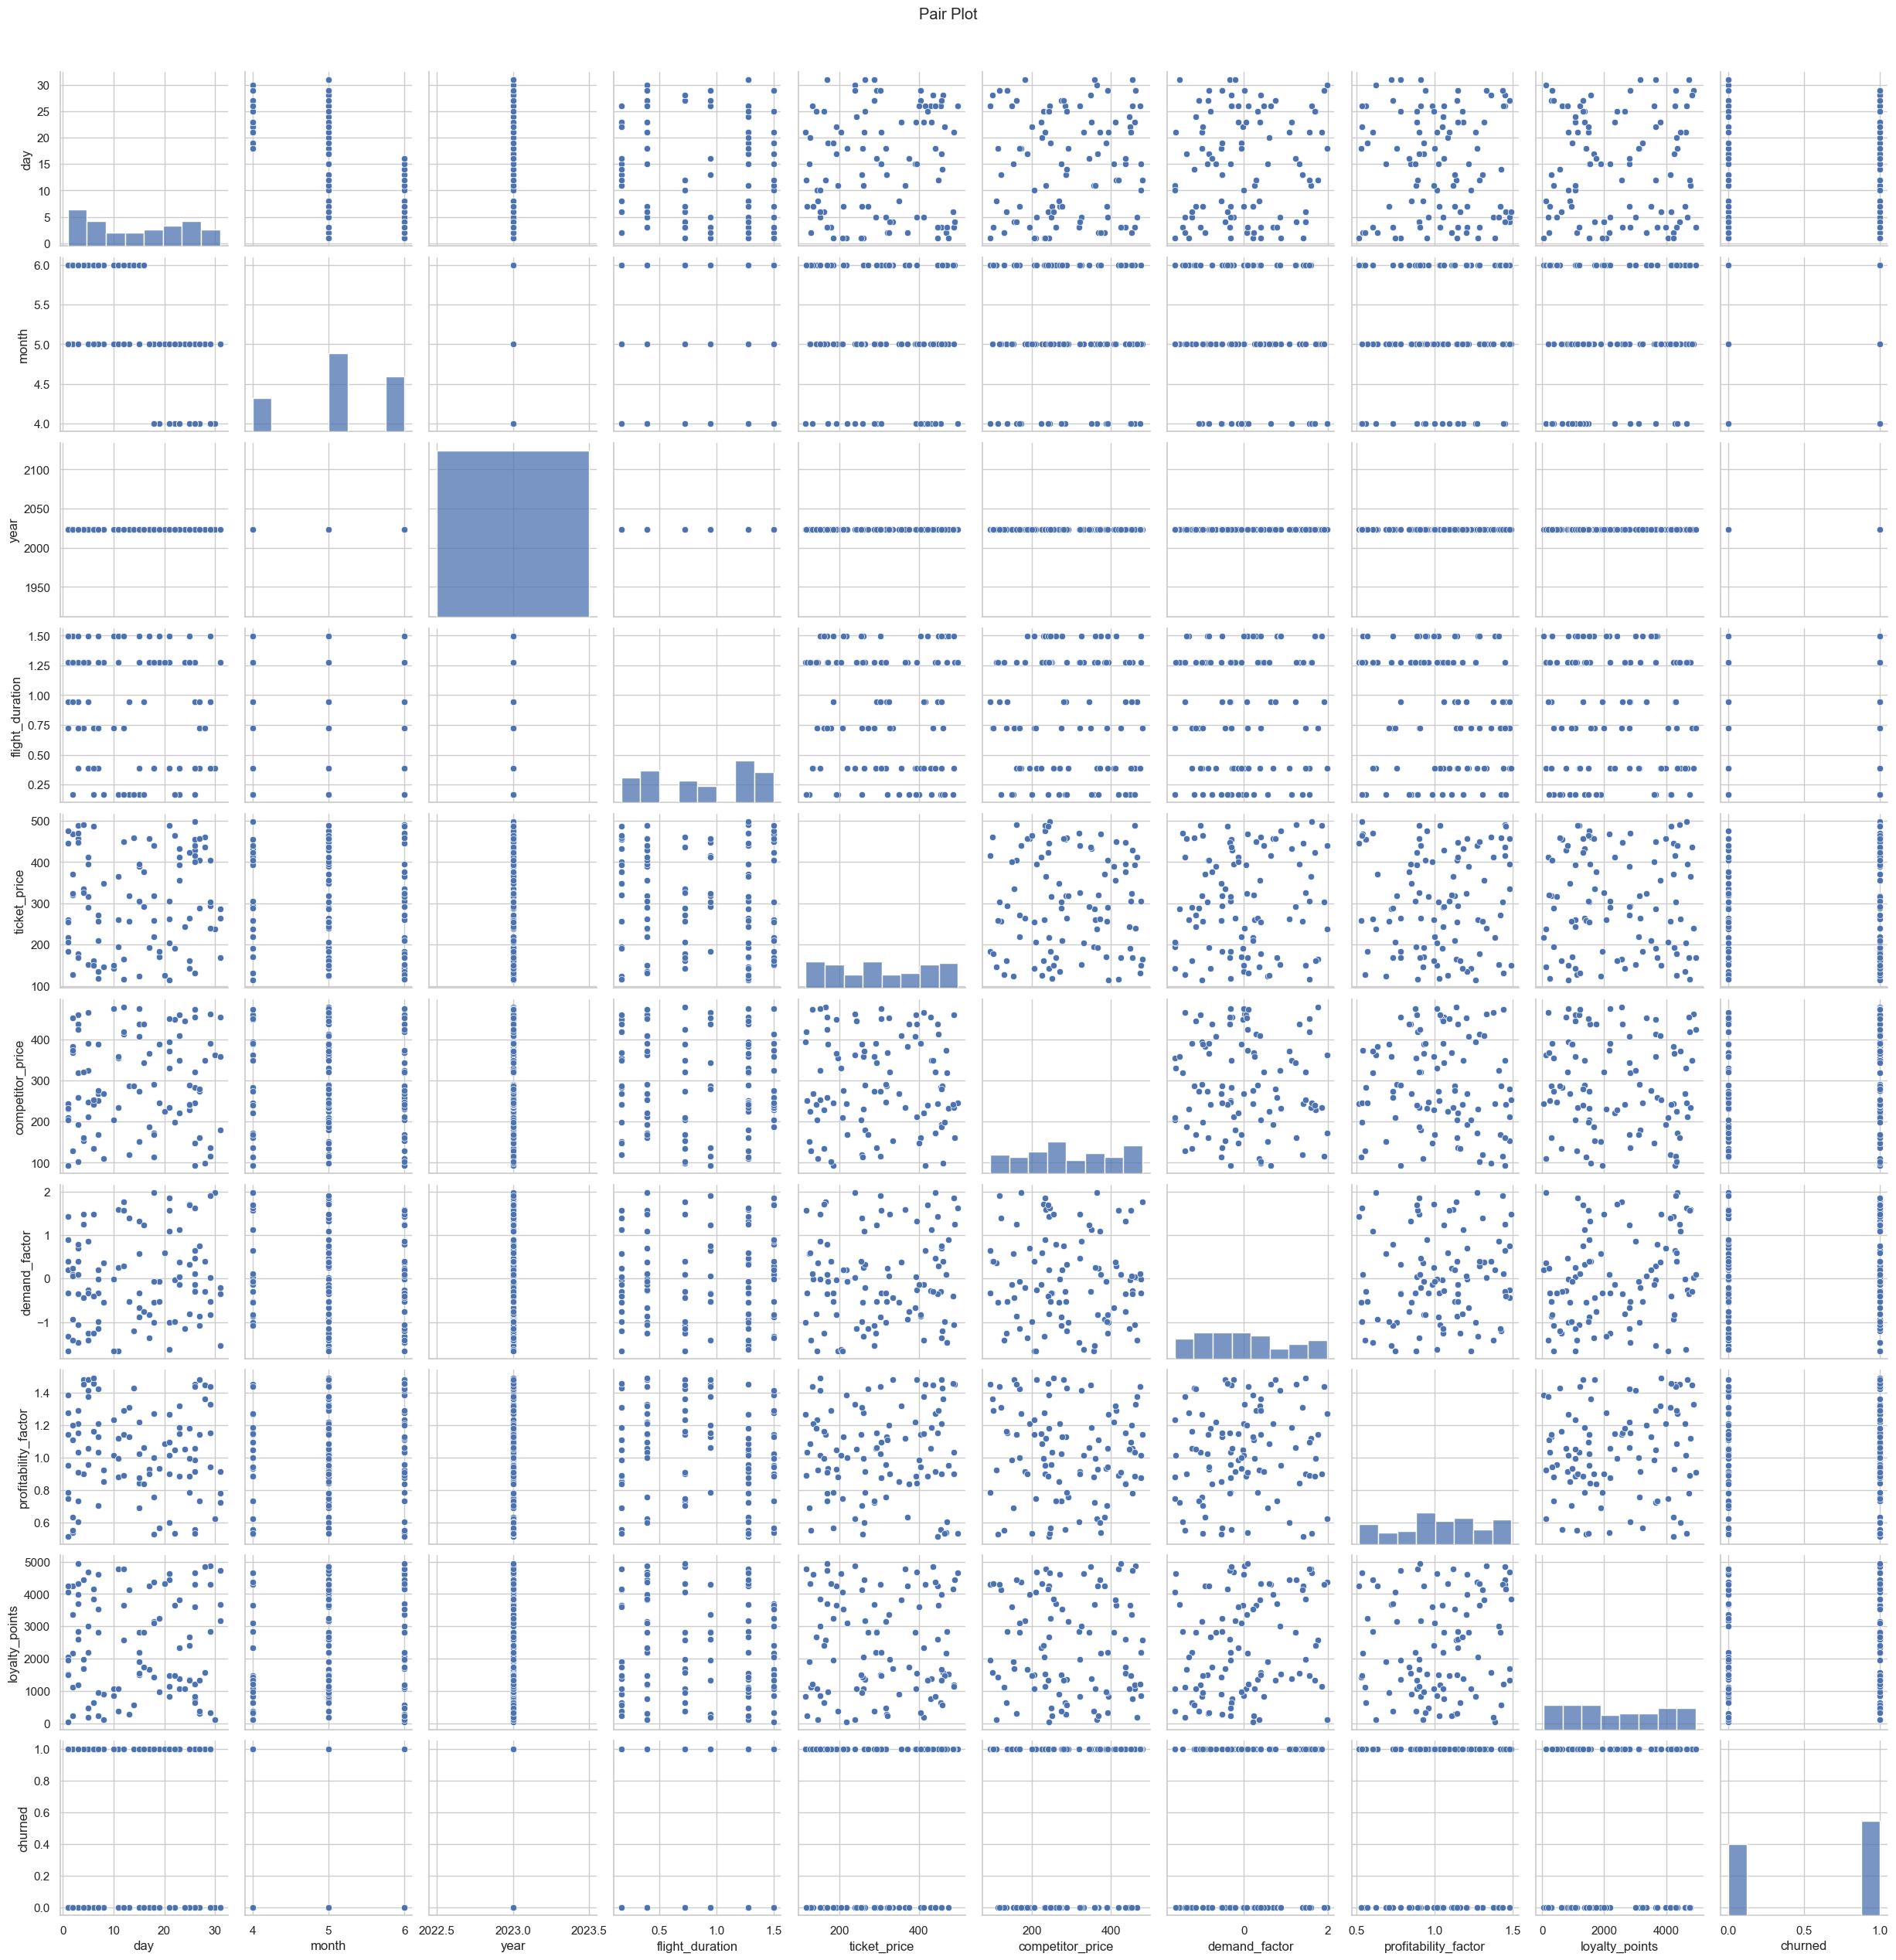

In [10]:
# Creating a pair plot
sn.pairplot(numeric_columns)
plt.suptitle('Pair Plot', y=1.02)  
plt.show()

<a id="prep"></a>
<h3 name='prep'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Data Preparation
            </span>   
        </font>    
</h3>

In [11]:
X_features = list( churn_df.columns )

X_features.remove( 'customerName' )
X_features.remove( 'departure_date' )
X_features.remove( 'departure_time' )
X_features.remove( 'day' )
X_features.remove( 'month' )
X_features.remove( 'year' )
X_features.remove( 'churned' )
X_features

['departure_city',
 'arrival_city',
 'time_category',
 'day_of_the_week',
 'flight_duration',
 'booking_class',
 'flyer_status',
 'route',
 'ticket_price',
 'competitor_price',
 'demand_factor',
 'origin_code',
 'destination_code',
 'profitability_factor',
 'loyalty_points']

In [12]:
# Perform one-hot encoding
encoded_churn_df = pd.get_dummies(churn_df[X_features], drop_first=True)
list(encoded_churn_df.columns)

['flight_duration',
 'ticket_price',
 'competitor_price',
 'demand_factor',
 'profitability_factor',
 'loyalty_points',
 'departure_city_Arnoldtown',
 'departure_city_Brianshire',
 'departure_city_Brittanyview',
 'departure_city_Brittneychester',
 'departure_city_Butlerside',
 'departure_city_Cobbshire',
 'departure_city_Coryton',
 'departure_city_Coxburgh',
 'departure_city_East Alejandra',
 'departure_city_East David',
 'departure_city_East Erica',
 'departure_city_East Francesborough',
 'departure_city_East Laura',
 'departure_city_East Lori',
 'departure_city_East Thomasland',
 'departure_city_Edwardsbury',
 'departure_city_Ericaton',
 'departure_city_Flowersburgh',
 'departure_city_Gregorystad',
 'departure_city_Gregville',
 'departure_city_Hardyberg',
 'departure_city_Hernandezmouth',
 'departure_city_Jameshaven',
 'departure_city_Jessicaburgh',
 'departure_city_Jonesside',
 'departure_city_Josechester',
 'departure_city_Josephtown',
 'departure_city_Josephview',
 'departure_city

<a id="build"></a>
<h3 name='build'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Building & Training the Classification Model
            </span>   
        </font>    
</h3>

In [13]:
# Splitting the data
Y = churn_df.churned
X = encoded_churn_df
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state=24)

In [14]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3,4]
}

# Create a Decision Tree Classifier
dtree = DecisionTreeClassifier()

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 2}


In [15]:
# Building Tree Classifier
clf_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf_tree.fit( X_train, y_train )
clf_tree

DecisionTreeClassifier(criterion='entropy', max_depth=2)

<a id="eval"></a>
<h3 name='eval'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Model Evaluation
            </span>   
        </font>    
</h3>

In [16]:
# Extracting the Probabilities
tree_predict = clf_tree.predict_proba( X_test )
tree_predict = pd.DataFrame(tree_predict) [1]
tree_predict = tree_predict.to_numpy()

In [17]:
y_pred_df = pd. DataFrame( { "actual": y_test,
                            "predicted_prob": tree_predict})
y_pred_df.sample(10, random_state = 24)
y_pred_df.shape

(20, 2)

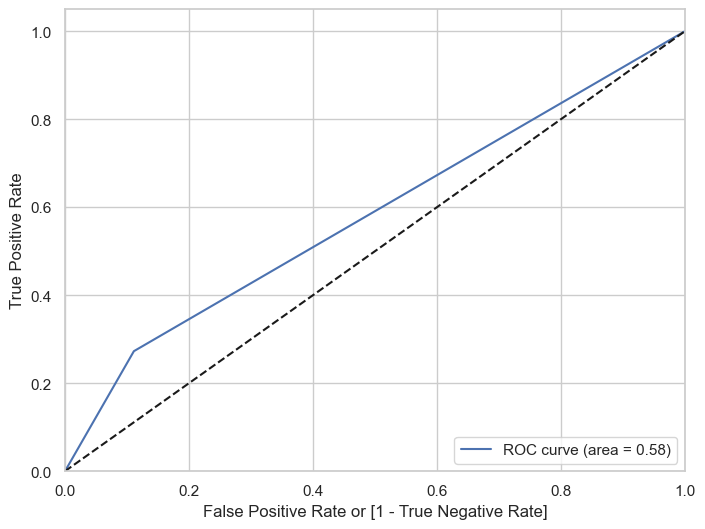

In [18]:
# Classifier Performance
metrics.roc_auc_score( y_test, y_pred_df.predicted_prob)
fpr, tpr, thresholds = draw_roc( y_test, y_pred_df.predicted_prob)

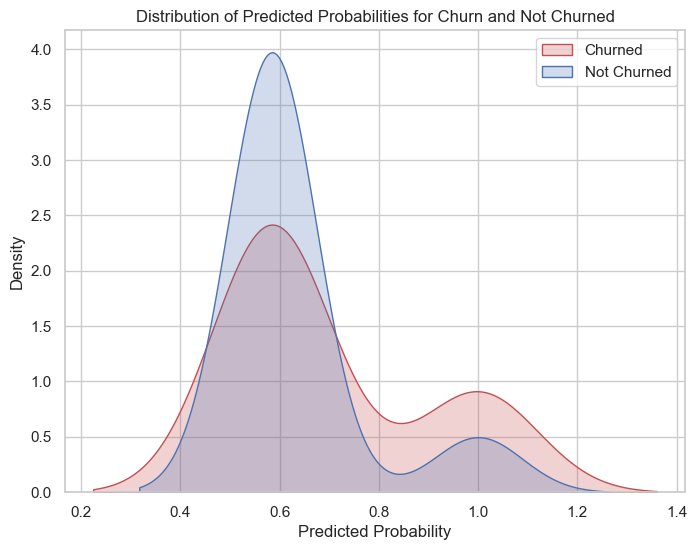

In [19]:
# Plotting Distributions and Identifying optimal probability
plt.figure(figsize=(8, 6))
sn.kdeplot(y_pred_df[y_pred_df.actual == 1]["predicted_prob"], color='r', shade=True, label='Churned')
sn.kdeplot(y_pred_df[y_pred_df.actual == 0]["predicted_prob"], color='b', shade=True, label='Not Churned')
plt.legend()
plt.title('Distribution of Predicted Probabilities for Churn and Not Churned')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()


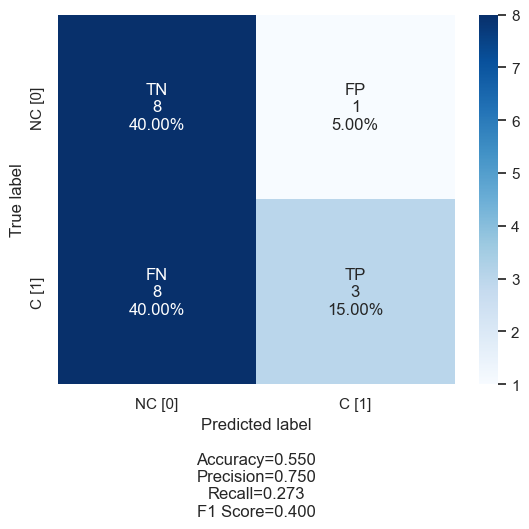

In [20]:
# Confusion Matrix and Performance Measures
y_pred_df['tree_predict'] = y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.75 else 0)
cf_matrix = metrics.confusion_matrix(y_pred_df.actual, y_pred_df.tree_predict)
labels = ["TN", "FP", "FN", "TP"]
categories = ["NC [0]", "C [1]"]
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap="Blues")


In [21]:
print( metrics.classification_report( y_pred_df['actual'], y_pred_df['tree_predict'] ))

              precision    recall  f1-score   support

           0       0.50      0.89      0.64         9
           1       0.75      0.27      0.40        11

    accuracy                           0.55        20
   macro avg       0.62      0.58      0.52        20
weighted avg       0.64      0.55      0.51        20



In [22]:
sorted_predict_df = y_pred_df[['predicted_prob','actual']].sort_values( 'predicted_prob',ascending = False )

num_per_decile = int( len( sorted_predict_df ) / 10 )
print( "Number of observations per decile: ", num_per_decile)

Number of observations per decile:  2


In [23]:
# Arrange by Deciles 
def get_deciles( df ):
    df['decile'] = 1
    idx = 0
    for each_d in range( 0, 10 ):
        df.iloc[idx:idx+num_per_decile, df.columns.get_loc('decile')] = each_d
        idx += num_per_decile
    df['decile'] = df['decile'] + 1
    return df

deciles_predict_df = get_deciles( sorted_predict_df )
deciles_predict_df[0:20]

predicted_prob  actual  decile
80        1.000000       1       1
76        1.000000       0       1
14        1.000000       1       2
75        1.000000       1       2
84        0.584615       0       3
61        0.584615       0       3
57        0.584615       0       4
20        0.584615       1       4
94        0.584615       1       5
40        0.584615       1       5
58        0.584615       0       6
26        0.584615       1       6
31        0.584615       0       7
67        0.584615       0       7
71        0.584615       0       8
48        0.584615       1       8
88        0.584615       1       9
86        0.584615       1       9
37        0.584615       1      10
13        0.584615       0      10

In [24]:
deciles_predict_df.actual.value_counts()

actual
1    11
0     9
Name: count, dtype: int64

In [25]:
# Calculating Gain Percentage 
gain_lift_df = pd.DataFrame(deciles_predict_df.groupby('decile')['actual'].sum() ).reset_index()
gain_lift_df.columns = ['decile', 'gain']
gain_lift_df['gain_percentage'] = (100 *gain_lift_df.gain.cumsum()/gain_lift_df.gain.sum())
gain_lift_df

decile  gain  gain_percentage
0       1     1         9.090909
1       2     2        27.272727
2       3     0        27.272727
3       4     1        36.363636
4       5     2        54.545455
5       6     1        63.636364
6       7     0        63.636364
7       8     1        72.727273
8       9     2        90.909091
9      10     1       100.000000

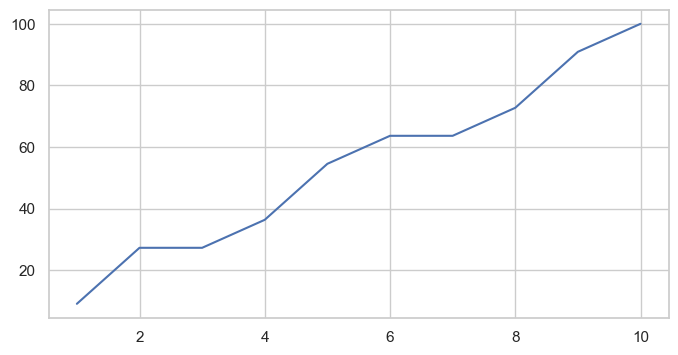

In [26]:
# Plotting Gain
plt.figure( figsize = (8,4)) 
plt.plot( gain_lift_df['decile'], gain_lift_df['gain_percentage'], '-' )
plt.show()

In [27]:
# Calculating Lift 
gain_lift_df['lift'] = ( gain_lift_df.gain_percentage / ( gain_lift_df.decile * 10) )
gain_lift_df

decile  gain  gain_percentage      lift
0       1     1         9.090909  0.909091
1       2     2        27.272727  1.363636
2       3     0        27.272727  0.909091
3       4     1        36.363636  0.909091
4       5     2        54.545455  1.090909
5       6     1        63.636364  1.060606
6       7     0        63.636364  0.909091
7       8     1        72.727273  0.909091
8       9     2        90.909091  1.010101
9      10     1       100.000000  1.000000

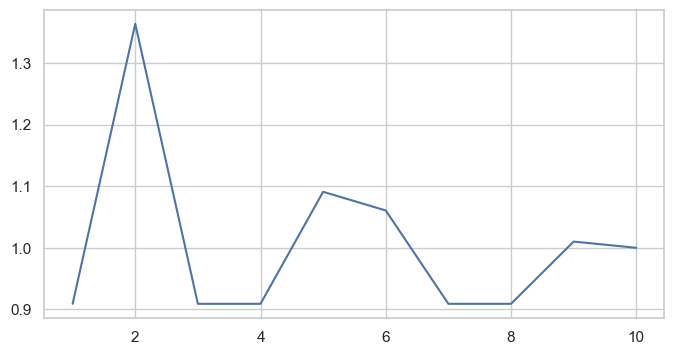

In [28]:
# Plotting Lift 
plt.figure( figsize = (8,4))
plt.plot( gain_lift_df['decile'], gain_lift_df['lift'], '-' )
plt.show()

<a id="save"></a>
<h5 name='save'>   
      <font color = blue >
            <span style='font-family:Georgia'>
            Saving the tree
            </span>   
        </font>    
</h5>

In [29]:
# Export the tree into odt file
export_graphviz( clf_tree, out_file = "chd_tree.odt", feature_names = X_train.columns,
class_names= ['Not Churned', 'Churned'], filled = True)

# Read the create the image file
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'chd_tree.odt' )
chd_tree_graph.write_jpg( 'chd_tree.png' )

Image(filename='chd_tree.png')

InvocationException: GraphViz's executables not found

<a id="sign"></a>
<h3 name='sign'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Identifying Significant & Influential features
            </span>   
        </font>    
</h3>

In [30]:
# Create a SHAP explainer for your model
explainer = shap.Explainer(clf_tree)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
shap_values[0][1]

array([ 0.    ,  0.0385,  0.    ,  0.    ,  0.    , -0.0482,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.  

In [31]:
features = encoded_churn_df.columns
features

Index(['flight_duration', 'ticket_price', 'competitor_price', 'demand_factor',
       'profitability_factor', 'loyalty_points', 'departure_city_Arnoldtown',
       'departure_city_Brianshire', 'departure_city_Brittanyview',
       'departure_city_Brittneychester',
       ...
       'booking_class_Economy', 'booking_class_First', 'flyer_status_Platinum',
       'flyer_status_Silver', 'route_MEL-BNE', 'route_SYD-MEL',
       'origin_code_MEL', 'origin_code_SYD', 'destination_code_LHR',
       'destination_code_SIN'],
      dtype='object', length=224)

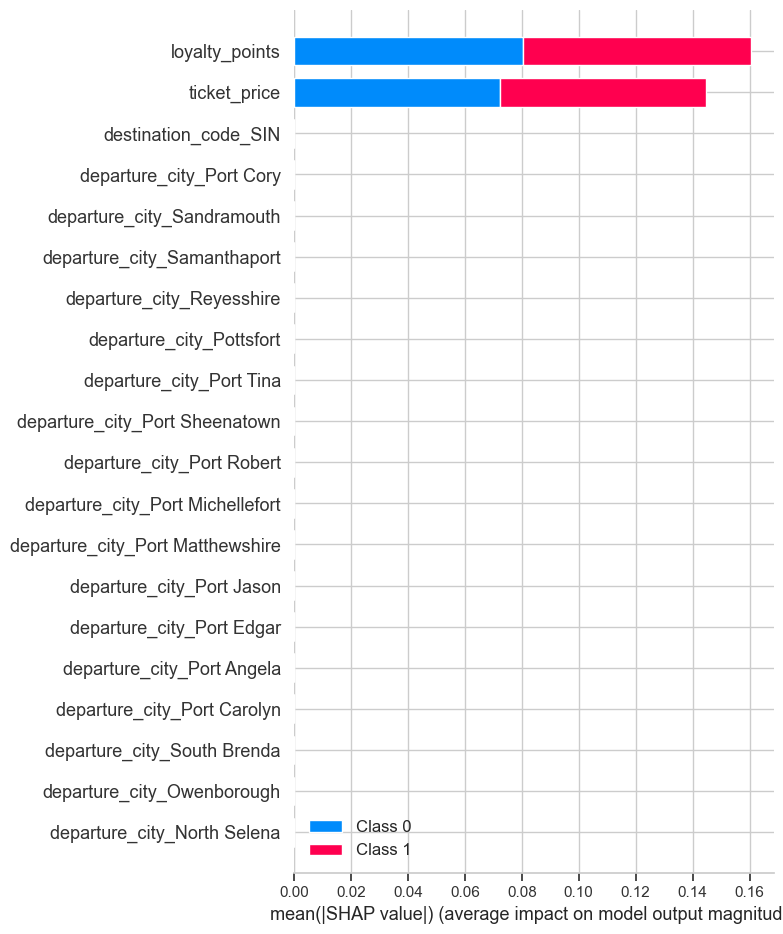

In [32]:
shap.summary_plot(shap_values,X_test,feature_names=encoded_churn_df.columns)

In [33]:
print(len(shap_values[0]), X_test.shape[1])

80 224


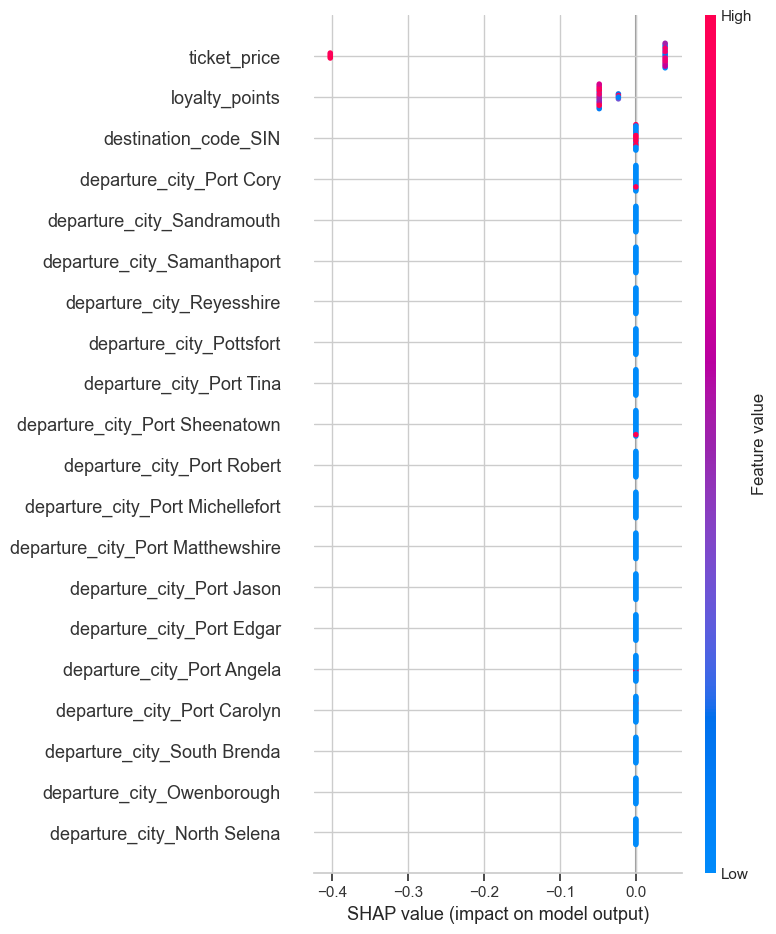

In [34]:
shap_values_test = explainer.shap_values(X_test)
shap.summary_plot(shap_values_test[0],X_test,feature_names=X_test.columns)

In [35]:
churn_df.groupby('churned')['loyalty_points'].mean()

churned
0    2169.558140
1    2557.035088
Name: loyalty_points, dtype: float64

In [36]:
churn_df.groupby('churned')['ticket_price'].mean()

churned
0    279.843087
1    321.060776
Name: ticket_price, dtype: float64

<a id="mod2"></a>
<h2 name='mod2'>   
      <font color = blue >
            <span style='font-family:Georgia'>
            Model 2: Price Optimization Model
            </span>   
        </font>    
</h2>

<a id="load1"></a>
<h3 name='load1'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Loading the Data
            </span>   
        </font>    
</h3>

In [37]:
chunk_size = 50000
chunks = pd.read_csv('flight_itenaries.csv', chunksize=chunk_size)

columns_to_remove = ['legId', 'segmentsDepartureTimeEpochSeconds','segmentsArrivalTimeEpochSeconds', 
                     'segmentsArrivalAirportCode','segmentsDepartureAirportCode', 'segmentsAirlineCode', 
                     'segmentsEquipmentDescription','segmentsCabinCode', 'data_connect','fareBasisCode',
                     'totalFare','segmentsAirlineName','elapsedDays','segmentsDistance','travelDuration',
                     'cost_per_gallon','gal_per_sec','totalConsumption']

processed_chunks = []  

for chunk in chunks:
    # Drop the unnecessary features
    chunk_dropped = chunk.drop(columns=columns_to_remove).copy()  # Ensure a copy is made
    processed_chunks.append(chunk_dropped)

itineraries_raw_df = pd.concat(processed_chunks, ignore_index=True)
itineraries_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548844 entries, 0 to 4548843
Data columns (total 23 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   searchDate                 object 
 1   flightDate                 object 
 2   startingAirport            object 
 3   destinationAirport         object 
 4   isBasicEconomy             bool   
 5   isRefundable               bool   
 6   isNonStop                  bool   
 7   baseFare                   float64
 8   seatsRemaining             int64  
 9   totalTravelDistance        float64
 10  segmentsDepartureTimeRaw   object 
 11  segmentsArrivalTimeRaw     object 
 12  segmentsDurationInSeconds  int64  
 13  fuelCost                   float64
 14  Key_Lime_fare              int64  
 15  Sun_Country_fare           float64
 16  Alaska_fare                float64
 17  American_fare              float64
 18  Cape_Air_fare              float64
 19  Frontier_fare              float64
 20  Je

In [38]:
itineraries_df = itineraries_raw_df.sample(n=500000, random_state=24)
itineraries_df.head()

searchDate  flightDate startingAirport destinationAirport  \
770913   2022-08-09  2022-09-08             CLT                JFK   
2426121  2022-07-28  2022-08-31             LAX                DTW   
187811   2022-09-03  2022-10-16             EWR                DTW   
4002112  2022-06-09  2022-07-24             ATL                LGA   
3335377  2022-07-24  2022-07-26             BOS                ORD   

         isBasicEconomy  isRefundable  isNonStop  baseFare  seatsRemaining  \
770913            False         False       True    180.47               1   
2426121           False         False       True    282.79               9   
187811            False         False       True    226.98               1   
4002112           False         False       True    222.33               4   
3335377            True         False       True    105.12               5   

         totalTravelDistance  ...      fuelCost Key_Lime_fare  \
770913                 545.0  ...   5521.521600             0   
2426121               1985.0  ...  27714.600000             0   
187811                 485.0  ...   5262.180000             0   
4002112                762.0  ...  14371.500000             0   
3335377                862.0  ...  11287.103906             0   

         Sun_Country_fare  Alaska_fare  American_fare  Cape_Air_fare  \
770913                0.0         0.00        140.465            0.0   
2426121               0.0       500.47        331.160            0.0   
187811                0.0         0.00        301.400            0.0   
4002112               0.0         0.00        224.190            0.0   
3335377               0.0         0.00        131.165            0.0   

         Frontier_fare  JetBlue_fare  Spirit_fare  United_fare  
770913            0.00       242.795          0.0        0.000  
2426121         121.29       378.610         72.0      465.585  
187811            0.00       337.680          0.0      287.445  
4002112         110.12       264.190          0.0      236.280  
3335377           0.00       175.820          0.0      143.260  

[5 rows x 23 columns]

In [39]:
itineraries_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 770913 to 2500336
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   searchDate                 500000 non-null  object 
 1   flightDate                 500000 non-null  object 
 2   startingAirport            500000 non-null  object 
 3   destinationAirport         500000 non-null  object 
 4   isBasicEconomy             500000 non-null  bool   
 5   isRefundable               500000 non-null  bool   
 6   isNonStop                  500000 non-null  bool   
 7   baseFare                   500000 non-null  float64
 8   seatsRemaining             500000 non-null  int64  
 9   totalTravelDistance        497182 non-null  float64
 10  segmentsDepartureTimeRaw   500000 non-null  object 
 11  segmentsArrivalTimeRaw     500000 non-null  object 
 12  segmentsDurationInSeconds  500000 non-null  int64  
 13  fuelCost                   5

<a id="prep1"></a>
<h3 name='prep1'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Data Preparation
            </span>   
        </font>    
</h3>

In [40]:
mean_totalTravelDistance = itineraries_df['totalTravelDistance'].mean()

# Impute null values with the mean
itineraries_df['totalTravelDistance'] = itineraries_df['totalTravelDistance'].fillna(mean_totalTravelDistance)

# List of competitor fare columns
competitor_columns = ['Key_Lime_fare', 'Sun_Country_fare', 'Alaska_fare', 'American_fare',
                       'Cape_Air_fare', 'Frontier_fare', 'JetBlue_fare', 'Spirit_fare', 'United_fare']

# Calculate average competitor price for each row
itineraries_df['avg_competitor_price'] = itineraries_df[competitor_columns].apply(lambda row: row[row > 0].mean(), axis=1)
itineraries_df = itineraries_df.drop(columns=competitor_columns)

itineraries_df['flightDate'] = pd.to_datetime(itineraries_df['flightDate'])
itineraries_df['searchDate'] = pd.to_datetime(itineraries_df['searchDate'])

itineraries_df['dayOfWeek'] = itineraries_df['flightDate'].dt.day_name()

itineraries_df['fare_deviation'] = itineraries_df['avg_competitor_price'] - itineraries_df['baseFare']

itineraries_df['days_left_to_fly'] = itineraries_df['flightDate'] - itineraries_df['searchDate']

# Convert 'segmentsDepartureTimeRaw' to datetime objects
itineraries_df['deptime_object'] = itineraries_df['segmentsDepartureTimeRaw'].apply(lambda x: parser.isoparse(x))
itineraries_df['departureTime'] = itineraries_df['deptime_object'].apply(lambda x: x.strftime('%H:%M'))

# Convert 'segmentsArrivalTimeRaw' to datetime objects
itineraries_df['arrtime_object'] = itineraries_df['segmentsArrivalTimeRaw'].apply(lambda x: parser.isoparse(x))

# If 'departureTime' is NaT, calculate it based on 'arrivalTime' and 'segmentsDurationInSeconds'
itineraries_df['departureTime'] = itineraries_df.apply(
    lambda row: row['arrivalTime'] + pd.Timedelta(seconds=row['segmentsDurationInSeconds'])
                 if pd.isna(row['departureTime']) else row['departureTime'],
    axis=1
)

# If 'arrtime_object' is NaT, calculate 'arrivalTime' based on 'departureTime' and 'segmentsDurationInSeconds'
itineraries_df['arrivalTime'] = itineraries_df.apply(
    lambda row: row['departureTime'] + pd.Timedelta(seconds=row['segmentsDurationInSeconds'])
                 if pd.isna(row['arrtime_object']) else row['arrtime_object'].strftime('%H:%M'),
    axis=1
)

# Define bins and labels for time of day
bins = [0, 5, 8, 12, 16, 20, 24]
labels = ['Post Mid Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

# Convert 'deptime_object' and 'arrtime_object' to datetime objects
itineraries_df['deptime_object'] = pd.to_datetime(itineraries_df['deptime_object'], errors='coerce')
itineraries_df['arrtime_object'] = pd.to_datetime(itineraries_df['arrtime_object'], errors='coerce')

# Create TimeOfDay columns for Departure and Arrival
itineraries_df['DepartureTimeOfDay'] = pd.cut(itineraries_df['deptime_object'].dt.hour, bins=bins, labels=labels, right=False)
itineraries_df['ArrivalTimeOfDay'] = pd.cut(itineraries_df['arrtime_object'].dt.hour, bins=bins, labels=labels, right=False)

# Set default values for the new columns
itineraries_df['DepartureTimeOfDay'] = itineraries_df['DepartureTimeOfDay'].fillna('Early Morning')
itineraries_df['ArrivalTimeOfDay'] = itineraries_df['ArrivalTimeOfDay'].fillna('Morning')

# Create interaction terms
itineraries_df['dayOfWeek_DepartureTimeOfDay'] = itineraries_df['dayOfWeek'].astype(str) + '_' + itineraries_df['DepartureTimeOfDay'].astype(str)
itineraries_df['dayOfWeek_ArrivalTimeOfDay'] = itineraries_df['dayOfWeek'].astype(str) + '_' + itineraries_df['ArrivalTimeOfDay'].astype(str)

itineraries_df['isBasicEconomy'] = itineraries_df['isBasicEconomy'].astype(int)
itineraries_df['isRefundable'] = itineraries_df['isRefundable'].astype(int)
itineraries_df['isNonStop'] = itineraries_df['isNonStop'].astype(int)
itineraries_df['days_left_to_fly'] = itineraries_df['days_left_to_fly'].dt.days.astype('int32')

itineraries_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 770913 to 2500336
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype                                 
---  ------                        --------------   -----                                 
 0   searchDate                    500000 non-null  datetime64[ns]                        
 1   flightDate                    500000 non-null  datetime64[ns]                        
 2   startingAirport               500000 non-null  object                                
 3   destinationAirport            500000 non-null  object                                
 4   isBasicEconomy                500000 non-null  int64                                 
 5   isRefundable                  500000 non-null  int64                                 
 6   isNonStop                     500000 non-null  int64                                 
 7   baseFare                      500000 non-null  float64          

<a id="desc1"></a>
<h3 name='desc1'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Descriptive Analytics
            </span>   
        </font>    
</h3>

In [41]:
itineraries_df.describe().transpose()

count                           mean  \
searchDate                   500000  2022-07-09 18:14:59.251200256   
flightDate                   500000  2022-08-05 23:59:22.502400256   
isBasicEconomy             500000.0                       0.299356   
isRefundable               500000.0                            0.0   
isNonStop                  500000.0                            1.0   
baseFare                   500000.0                     220.939581   
seatsRemaining             500000.0                       7.519998   
totalTravelDistance        500000.0                     851.384177   
segmentsDurationInSeconds  500000.0                     9199.02216   
fuelCost                   500000.0                   21350.861292   
avg_competitor_price       499996.0                     254.304033   
fare_deviation             499996.0                      33.365133   
days_left_to_fly           500000.0                      27.239158   

                                           min                  25%  \
searchDate                 2022-04-16 00:00:00  2022-05-31 00:00:00   
flightDate                 2022-04-17 00:00:00  2022-06-27 00:00:00   
isBasicEconomy                             0.0                  0.0   
isRefundable                               0.0                  0.0   
isNonStop                                  1.0                  1.0   
baseFare                                 22.33               124.65   
seatsRemaining                             1.0                  7.0   
totalTravelDistance                      185.0                485.0   
segmentsDurationInSeconds               3840.0               6540.0   
fuelCost                             1831.9032              5925.48   
avg_competitor_price                 48.681667             169.7177   
fare_deviation                    -1485.686667              -23.031   
days_left_to_fly                           1.0                 13.0   

                                           50%                  75%  \
searchDate                 2022-07-10 00:00:00  2022-08-18 00:00:00   
flightDate                 2022-08-08 00:00:00  2022-09-15 00:00:00   
isBasicEconomy                             0.0                  1.0   
isRefundable                               0.0                  0.0   
isNonStop                                  1.0                  1.0   
baseFare                                189.77               282.79   
seatsRemaining                             9.0                  9.0   
totalTravelDistance                      720.0               1104.0   
segmentsDurationInSeconds               8040.0              10680.0   
fuelCost                              11147.46           21495.0528   
avg_competitor_price                 229.27625           310.581562   
fare_deviation                          33.749            88.533333   
days_left_to_fly                          26.0                 40.0   

                                           max           std  
searchDate                 2022-10-05 00:00:00           NaN  
flightDate                 2022-11-19 00:00:00           NaN  
isBasicEconomy                             1.0      0.457976  
isRefundable                               0.0           0.0  
isNonStop                                  1.0           0.0  
baseFare                                2310.7    128.732033  
seatsRemaining                            10.0      2.558505  
totalTravelDistance                     2698.0    570.251576  
segmentsDurationInSeconds              25500.0   3937.454702  
fuelCost                         211938.857165  30626.589562  
avg_competitor_price                 2295.1175    122.067828  
fare_deviation                        1844.415    110.845192  
days_left_to_fly                          60.0     16.282321

In [42]:
# Identify non-numeric columns
i_non_numeric_columns = itineraries_df.select_dtypes(exclude=['number']).columns

# Display unique values and counts for each non-numeric column
for column in i_non_numeric_columns:
    unique_values_counts = itineraries_df[column].value_counts()
    print(f"Unique values for '{column}':")
    print(unique_values_counts)
    print("\n" + "="*50 + "\n")  # Separating each column's output for clarity


Unique values for 'searchDate':
searchDate
2022-04-21    3669
2022-05-05    3650
2022-06-03    3644
2022-07-10    3641
2022-07-16    3640
              ... 
2022-05-11     705
2022-04-16     598
2022-09-20     255
2022-05-17     217
2022-08-29      82
Name: count, Length: 171, dtype: int64


Unique values for 'flightDate':
flightDate
2022-08-25    3779
2022-08-26    3750
2022-08-08    3682
2022-08-11    3633
2022-08-29    3625
              ... 
2022-04-20     213
2022-04-19     177
2022-11-19     111
2022-04-18     110
2022-04-17      73
Name: count, Length: 217, dtype: int64


Unique values for 'startingAirport':
startingAirport
ATL    109419
DTW     58675
LGA     50546
BOS     48262
JFK     36268
LAX     35042
ORD     24673
DFW     23801
CLT     22264
DEN     17660
MIA     17590
SFO     15461
EWR     14565
PHL     12084
IAD     10894
OAK      2796
Name: count, dtype: int64


Unique values for 'destinationAirport':
destinationAirport
ATL    108868
DTW     59129
LGA     50923
BOS     

<a id="eda1"></a>
<h3 name='eda1'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Exploratory Data Analytics
            </span>   
        </font>    
</h3>

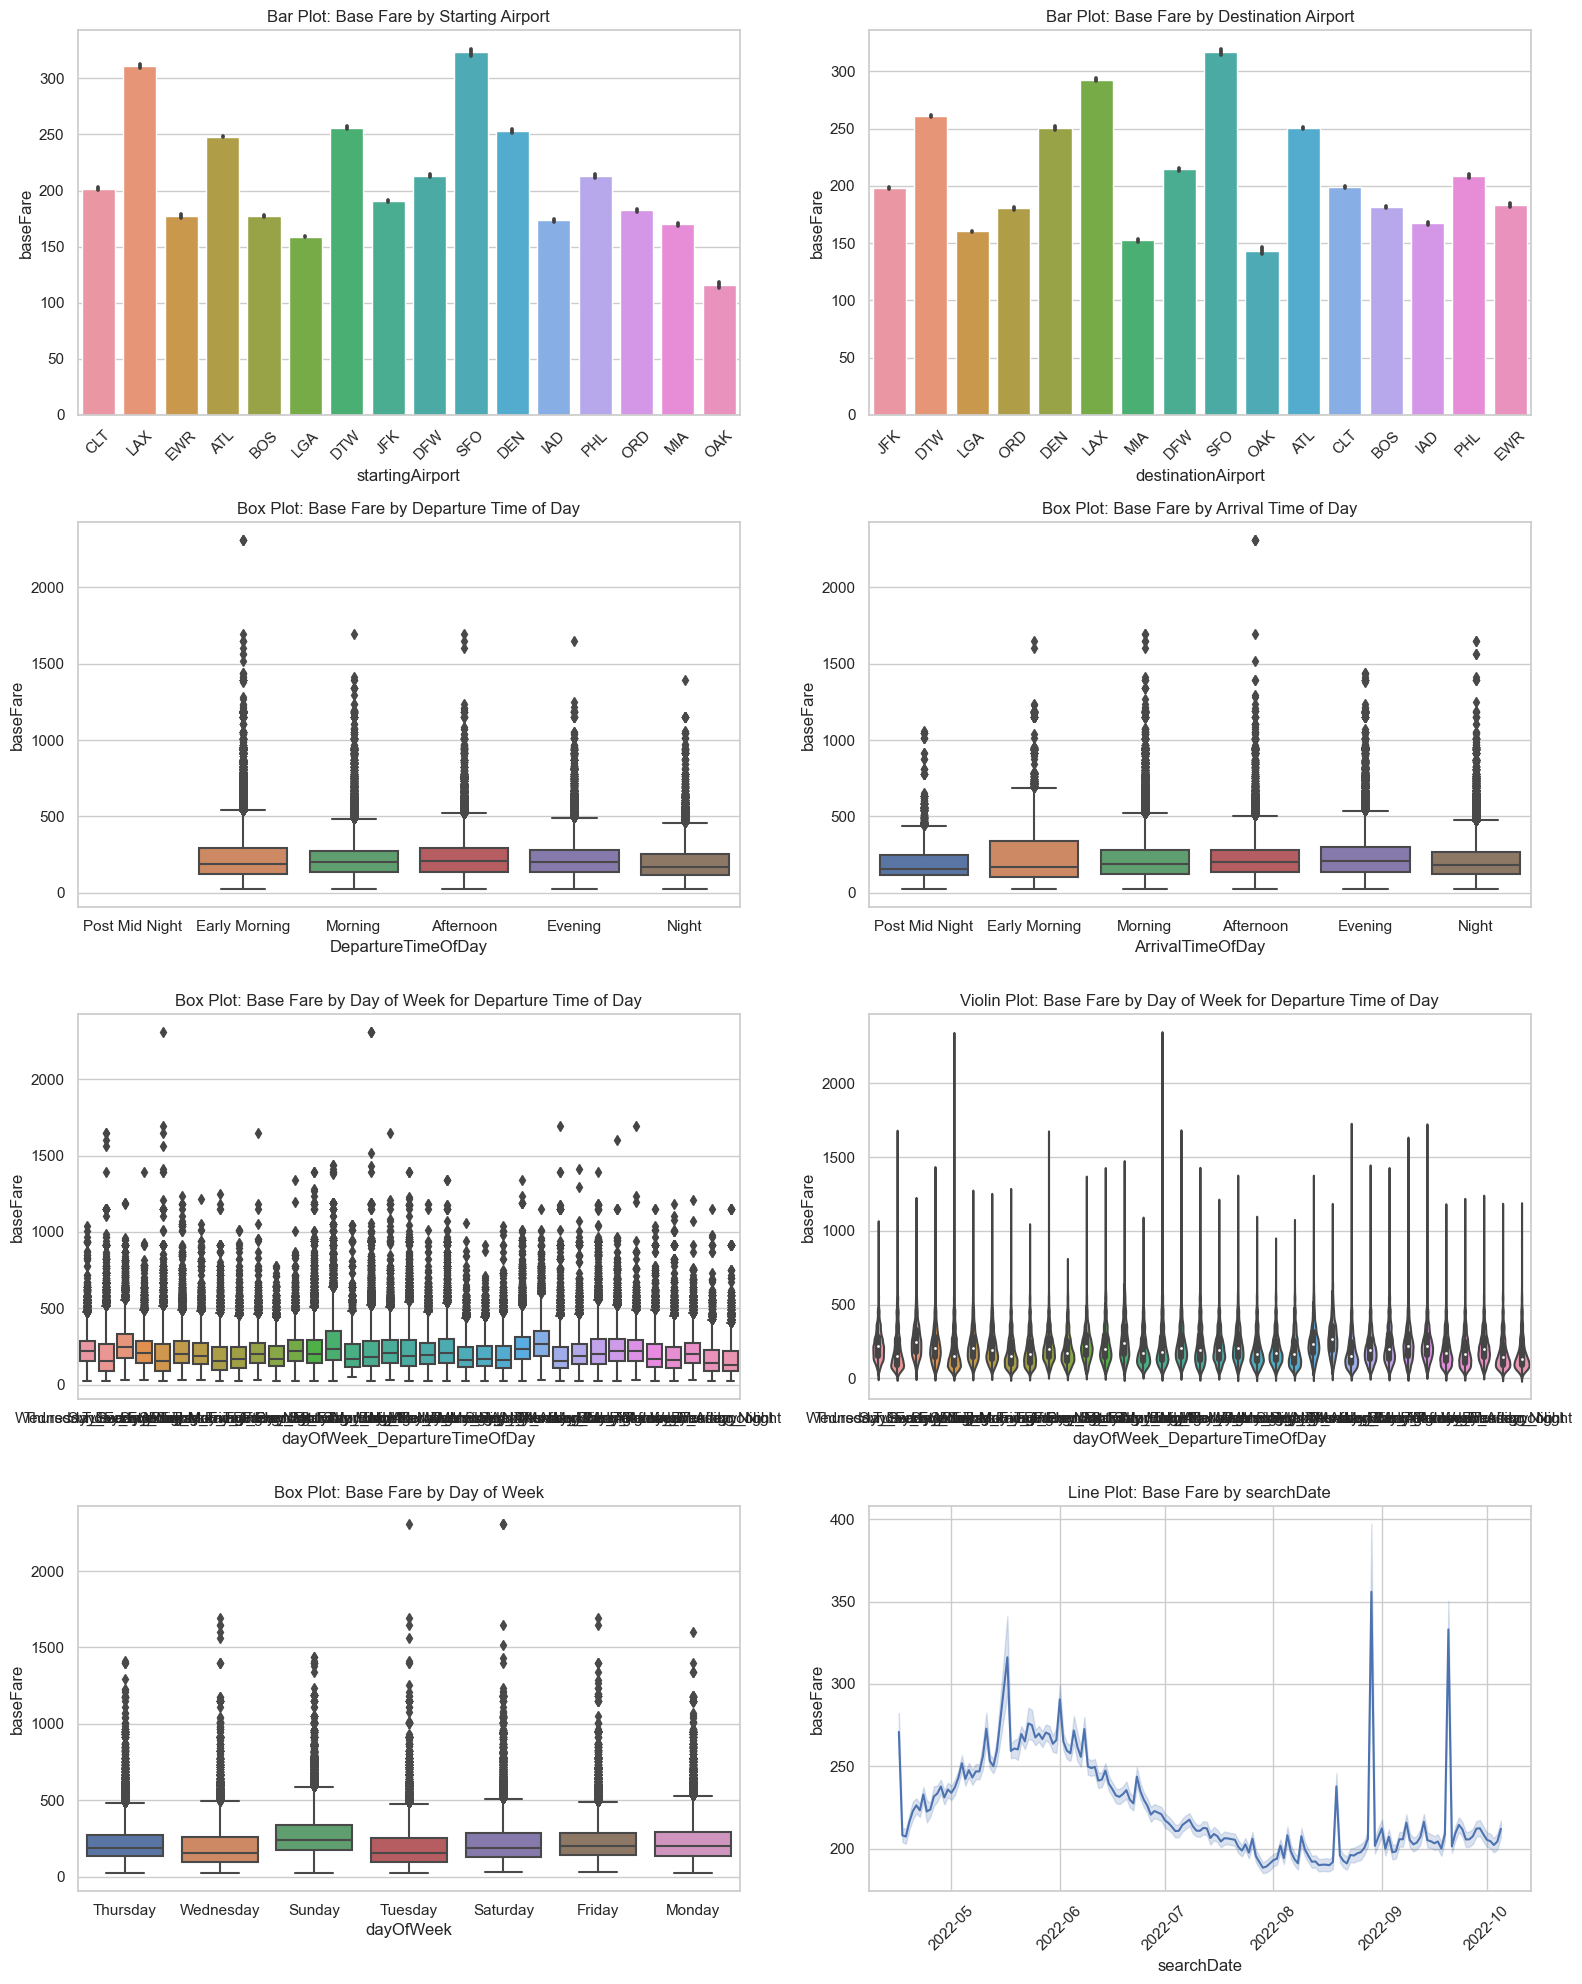

In [43]:
# Set Seaborn style
sn.set(style="whitegrid")

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

# EDA with 'baseFare' for Non-Numeric Columns

# Bar plot: Base Fare by Starting Airport
sn.barplot(x='startingAirport', y='baseFare', data=itineraries_df, ax=axes[0, 0])
axes[0, 0].set_title('Bar Plot: Base Fare by Starting Airport')
axes[0, 0].tick_params(axis='x', rotation=45)

# Bar plot: Base Fare by Destination Airport
sn.barplot(x='destinationAirport', y='baseFare', data=itineraries_df, ax=axes[0, 1])
axes[0, 1].set_title('Bar Plot: Base Fare by Destination Airport')
axes[0, 1].tick_params(axis='x', rotation=45)

# Box plot: Base Fare by Departure Time of Day
sn.boxplot(x='DepartureTimeOfDay', y='baseFare', data=itineraries_df, ax=axes[1, 0])
axes[1, 0].set_title('Box Plot: Base Fare by Departure Time of Day')

# Box plot: Base Fare by Arrival Time of Day
sn.boxplot(x='ArrivalTimeOfDay', y='baseFare', data=itineraries_df, ax=axes[1, 1])
axes[1, 1].set_title('Box Plot: Base Fare by Arrival Time of Day')

# Box plot: Base Fare by Day of Week for Departure Time of Day
sn.boxplot(x='dayOfWeek_DepartureTimeOfDay', y='baseFare', data=itineraries_df, ax=axes[2, 0])
axes[2, 0].set_title('Box Plot: Base Fare by Day of Week for Departure Time of Day')

# Violin plot: Base Fare by Day of Week for Departure Time of Day
sn.violinplot(x='dayOfWeek_DepartureTimeOfDay', y='baseFare', data=itineraries_df, ax=axes[2, 1])
axes[2, 1].set_title('Violin Plot: Base Fare by Day of Week for Departure Time of Day')

# Box plot: Base Fare by Day of Week
sn.boxplot(x='dayOfWeek', y='baseFare', data=itineraries_df, ax=axes[3, 0])
axes[3, 0].set_title('Box Plot: Base Fare by Day of Week')

# Line plot: Base Fare by searchDate
sn.lineplot(x='searchDate', y='baseFare', data=itineraries_df, ax=axes[3, 1])
axes[3, 1].set_title('Line Plot: Base Fare by searchDate')
axes[3, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


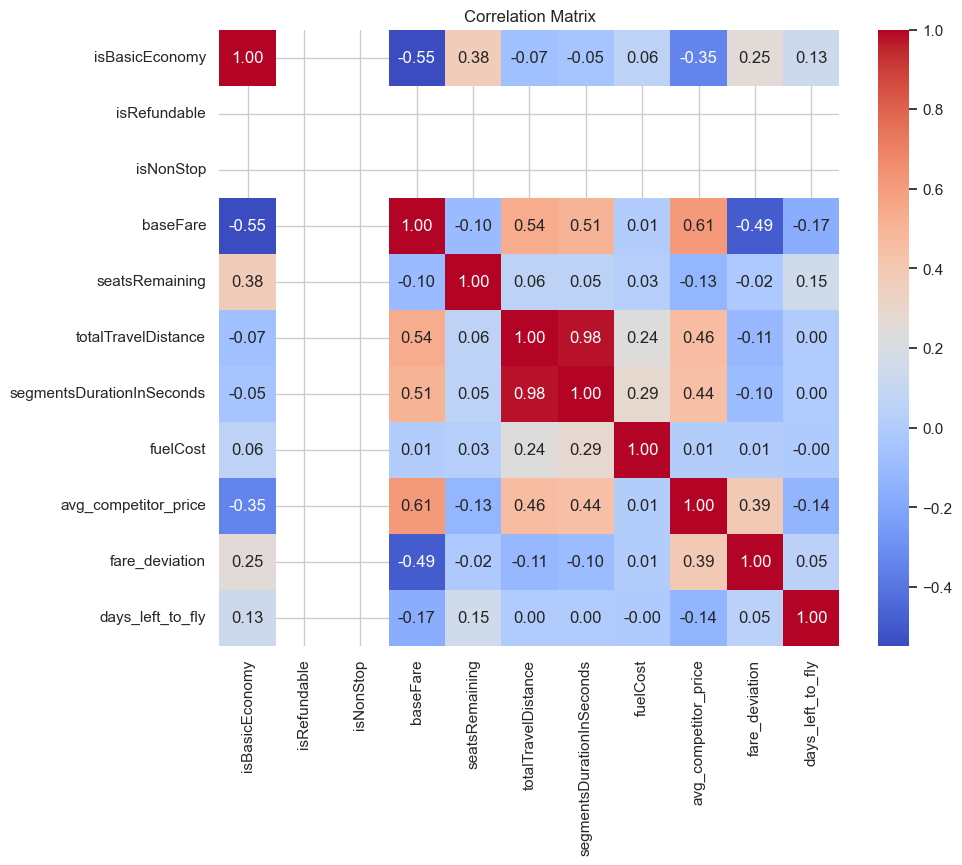

In [44]:
# Creating Correlation Matrix
i_numeric_columns = itineraries_df.select_dtypes(include=['number'])

# Build correlation matrix
i_correlation_matrix_numeric = i_numeric_columns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with Seaborn
sn.heatmap(i_correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

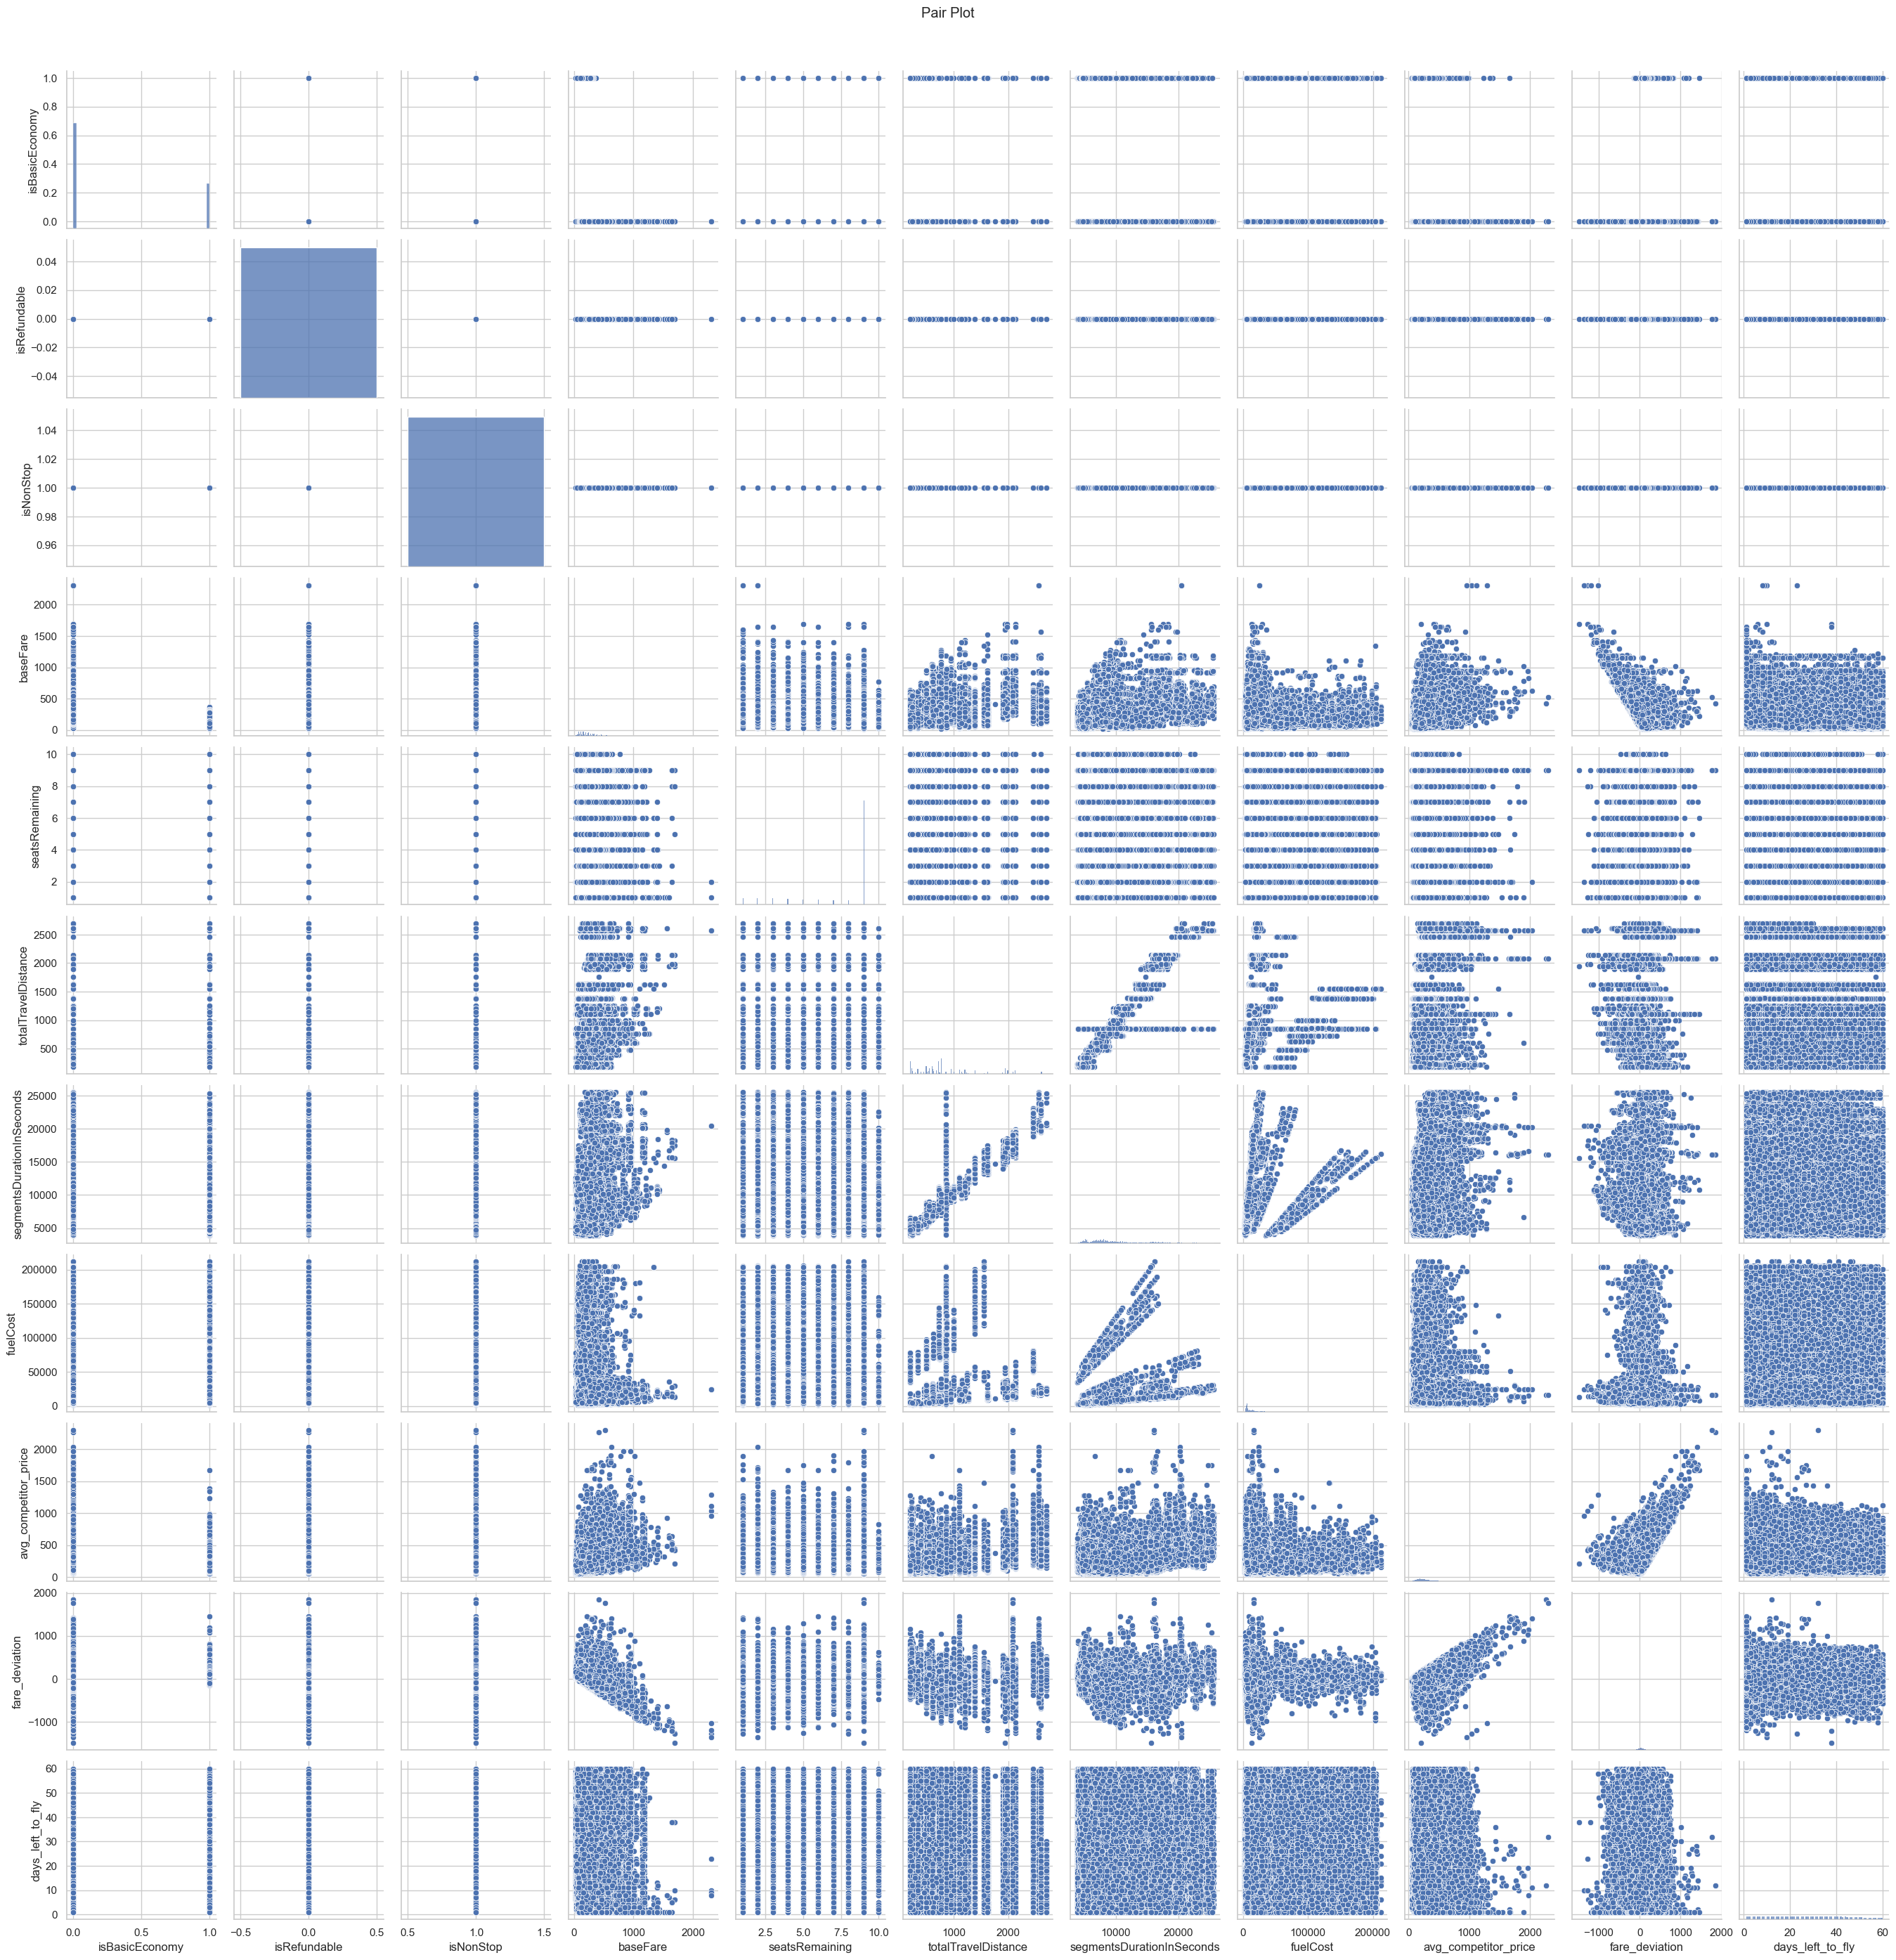

In [45]:
# Creating a pair plot
sn.pairplot(i_numeric_columns)
plt.suptitle('Pair Plot', y=1.02)  
plt.show()

<a id="build1"></a>
<h3 name='build1'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Building & Training the Classification Model
            </span>   
        </font>    
</h3>

In [46]:
X_features = list( itineraries_df.columns )

X_features.remove( 'baseFare' )
X_features.remove( 'arrivalTime' )
X_features.remove( 'arrtime_object' )
X_features.remove( 'departureTime' )
X_features.remove( 'deptime_object' )
X_features.remove( 'searchDate' )
X_features.remove( 'flightDate' )
X_features.remove( 'segmentsDepartureTimeRaw' )
X_features.remove( 'segmentsArrivalTimeRaw' )
X_features.remove( 'fare_deviation' )

X_features

['startingAirport',
 'destinationAirport',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDurationInSeconds',
 'fuelCost',
 'avg_competitor_price',
 'dayOfWeek',
 'days_left_to_fly',
 'DepartureTimeOfDay',
 'ArrivalTimeOfDay',
 'dayOfWeek_DepartureTimeOfDay',
 'dayOfWeek_ArrivalTimeOfDay']

In [47]:
# Perform one-hot encoding
encoded_predictor_df = pd.get_dummies(itineraries_df[X_features], drop_first=True)
list(encoded_predictor_df.columns)

['isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDurationInSeconds',
 'fuelCost',
 'avg_competitor_price',
 'days_left_to_fly',
 'startingAirport_BOS',
 'startingAirport_CLT',
 'startingAirport_DEN',
 'startingAirport_DFW',
 'startingAirport_DTW',
 'startingAirport_EWR',
 'startingAirport_IAD',
 'startingAirport_JFK',
 'startingAirport_LAX',
 'startingAirport_LGA',
 'startingAirport_MIA',
 'startingAirport_OAK',
 'startingAirport_ORD',
 'startingAirport_PHL',
 'startingAirport_SFO',
 'destinationAirport_BOS',
 'destinationAirport_CLT',
 'destinationAirport_DEN',
 'destinationAirport_DFW',
 'destinationAirport_DTW',
 'destinationAirport_EWR',
 'destinationAirport_IAD',
 'destinationAirport_JFK',
 'destinationAirport_LAX',
 'destinationAirport_LGA',
 'destinationAirport_MIA',
 'destinationAirport_OAK',
 'destinationAirport_ORD',
 'destinationAirport_PHL',
 'destinationAirport_SFO',
 'dayOfWeek_Monday',
 'dayOfWeek_Saturday',
 'dayOfWe

In [48]:
# Convert all boolean columns to integers
boolean_columns = encoded_predictor_df.select_dtypes(include='bool').columns
encoded_predictor_df[boolean_columns] = encoded_predictor_df[boolean_columns].astype(int)
encoded_predictor_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 770913 to 2500336
Columns: 130 entries, isBasicEconomy to dayOfWeek_ArrivalTimeOfDay_Wednesday_Post Mid Night
dtypes: float64(3), int32(1), int64(126)
memory usage: 497.8 MB


In [49]:
print(encoded_predictor_df.isnull().sum())

# Handle missing values by filling with mean
encoded_predictor_df = encoded_predictor_df.fillna(encoded_predictor_df.mean())

isBasicEconomy                                         0
isRefundable                                           0
isNonStop                                              0
seatsRemaining                                         0
totalTravelDistance                                    0
                                                      ..
dayOfWeek_ArrivalTimeOfDay_Wednesday_Early Morning     0
dayOfWeek_ArrivalTimeOfDay_Wednesday_Evening           0
dayOfWeek_ArrivalTimeOfDay_Wednesday_Morning           0
dayOfWeek_ArrivalTimeOfDay_Wednesday_Night             0
dayOfWeek_ArrivalTimeOfDay_Wednesday_Post Mid Night    0
Length: 130, dtype: int64


In [50]:
X = encoded_predictor_df
Y = itineraries_df['baseFare']
X = sm.add_constant(X,has_constant='add') 
X.shape

(500000, 131)

In [51]:
train_X, test_X, train_y, test_y = train_test_split( X , Y, train_size = 0.7, random_state = 24 )

print("Rows Train X:", len(train_X.index), "Columns Train X:", len(train_X.columns))
print("Rows Test X:", len(test_X.index), "Columns Test X:", len(test_X.columns))
print("Length Train y:", len(train_y))
print("Length Test y:", len(test_y))

Rows Train X: 350000 Columns Train X: 131
Rows Test X: 150000 Columns Test X: 131
Length Train y: 350000
Length Test y: 150000


In [52]:
# Model Building process will take several iterations
model = sm.OLS(train_y, train_X).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                           OLS                           Adj. R-squared:                  0.671       
Dependent Variable:              baseFare                      AIC:                             4005518.6825
Date:                            2024-02-19 19:11              BIC:                             4006670.6111
No. Observations:                350000                        Log-Likelihood:                  -2.0027e+06 
Df Model:                        106                           F-statistic:                     6726.       
Df Residuals:                    349893                        Prob (F-statistic):              0.00        
R-squared:                       0.671                         Scale:                           5465.2      
------------------------------------------------------------------------------------------------------------
                                                       Coef.   Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------------------------------------------------
const                                                  53.3778   0.5191  102.8322 0.0000   52.3604   54.3952
isBasicEconomy                                       -104.7312   0.3401 -307.9653 0.0000 -105.3978 -104.0647
isRefundable                                           -0.0000   0.0000 -322.2965 0.0000   -0.0000   -0.0000
isNonStop                                              53.3778   0.5191  102.8322 0.0000   52.3604   54.3952
seatsRemaining                                          3.6976   0.0547   67.5896 0.0000    3.5904    3.8048
totalTravelDistance                                     0.0131   0.0020    6.6948 0.0000    0.0093    0.0169
segmentsDurationInSeconds                               0.0098   0.0003   35.3010 0.0000    0.0092    0.0103
fuelCost                                               -0.0001   0.0000  -25.2852 0.0000   -0.0002   -0.0001
avg_competitor_price                                    0.3123   0.0014  218.2475 0.0000    0.3095    0.3151
days_left_to_fly                                       -0.7011   0.0079  -88.7843 0.0000   -0.7166   -0.6856
startingAirport_BOS                                   -43.3384   0.6040  -71.7570 0.0000  -44.5221  -42.1546
startingAirport_CLT                                   -47.1199   0.7303  -64.5253 0.0000  -48.5512  -45.6887
startingAirport_DEN                                   -52.3677   0.8792  -59.5595 0.0000  -54.0910  -50.6444
startingAirport_DFW                                   -42.4685   0.8725  -48.6726 0.0000  -44.1787  -40.7584
startingAirport_DTW                                     0.2912   0.4670    0.6237 0.5328   -0.6240    1.2065
startingAirport_EWR                                   -62.8336   0.8652  -72.6234 0.0000  -64.5294  -61.1378
startingAirport_IAD                                   -73.6681   0.9844  -74.8324 0.0000  -75.5976  -71.7387
startingAirport_JFK                                   -55.2680   0.7342  -75.2714 0.0000  -56.7071  -53.8289
startingAirport_LAX                                   -21.7829   0.7856  -27.7272 0.0000  -23.3227  -20.2431
startingAirport_LGA                                   -52.7928   0.6740  -78.3307 0.0000  -54.1137  -51.4718
startingAirport_MIA                                   -71.3315   0.7754  -91.9957 0.0000  -72.8512  -69.8118
startingAirport_OAK                                  -102.8365   1.8668  -55.0874 0.0000 -106.4953  -99.1776
startingAirport_ORD                                   -42.9840   0.8252  -52.0895 0.0000  -44.6013  -41.3666
startingAirport_PHL                                   -32.1430   0.9253  -34.7373 0.0000  -33.9566  -30.3294
startingAirport_SFO                                   -26.8200   0

In [53]:
significant_vars = model.pvalues.where(model.pvalues < 0.05).dropna()
significant_vars = significant_vars.index.tolist()
significant_vars 

['const',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDurationInSeconds',
 'fuelCost',
 'avg_competitor_price',
 'days_left_to_fly',
 'startingAirport_BOS',
 'startingAirport_CLT',
 'startingAirport_DEN',
 'startingAirport_DFW',
 'startingAirport_EWR',
 'startingAirport_IAD',
 'startingAirport_JFK',
 'startingAirport_LAX',
 'startingAirport_LGA',
 'startingAirport_MIA',
 'startingAirport_OAK',
 'startingAirport_ORD',
 'startingAirport_PHL',
 'startingAirport_SFO',
 'destinationAirport_BOS',
 'destinationAirport_CLT',
 'destinationAirport_DEN',
 'destinationAirport_DFW',
 'destinationAirport_EWR',
 'destinationAirport_IAD',
 'destinationAirport_JFK',
 'destinationAirport_LAX',
 'destinationAirport_LGA',
 'destinationAirport_MIA',
 'destinationAirport_OAK',
 'destinationAirport_ORD',
 'destinationAirport_PHL',
 'destinationAirport_SFO',
 'dayOfWeek_Monday',
 'dayOfWeek_Saturday',
 'dayOfWeek_Sunday',
 'dayOfWeek_Thursday',
 'dayO

In [54]:
train_X = train_X[significant_vars]
test_X  = test_X[significant_vars]

print("Rows Train X:", len(train_X.index), "Columns Train X:", len(train_X.columns))
print("Rows Test X:", len(test_X.index), "Columns Test X:", len(test_X.columns))
print("Length Train y:", len(train_y))
print("Length Test y:", len(test_y))

Rows Train X: 350000 Columns Train X: 105
Rows Test X: 150000 Columns Test X: 105
Length Train y: 350000
Length Test y: 150000


In [55]:
significant_model = sm.OLS(train_y, train_X).fit()
significant_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                           OLS                           Adj. R-squared:                  0.671       
Dependent Variable:              baseFare                      AIC:                             4005516.2154
Date:                            2024-02-19 19:12              BIC:                             4006603.5499
No. Observations:                350000                        Log-Likelihood:                  -2.0027e+06 
Df Model:                        100                           F-statistic:                     7129.       
Df Residuals:                    349899                        Prob (F-statistic):              0.00        
R-squared:                       0.671                         Scale:                           5465.3      
------------------------------------------------------------------------------------------------------------
                                                       Coef.   Std.Err.     t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------------------------------------------------
const                                                  53.7783   1.2552   42.8460 0.0000   51.3182   56.2383
isBasicEconomy                                       -104.7407   0.3399 -308.1405 0.0000 -105.4069 -104.0745
isRefundable                                           -0.0000   0.0000  -27.8578 0.0000   -0.0000   -0.0000
isNonStop                                              53.7783   1.2552   42.8460 0.0000   51.3182   56.2383
seatsRemaining                                          3.6998   0.0547   67.6918 0.0000    3.5927    3.8069
totalTravelDistance                                     0.0132   0.0019    6.8367 0.0000    0.0094    0.0170
segmentsDurationInSeconds                               0.0098   0.0003   35.5603 0.0000    0.0092    0.0103
fuelCost                                               -0.0001   0.0000  -25.4154 0.0000   -0.0002   -0.0001
avg_competitor_price                                    0.3121   0.0014  220.5808 0.0000    0.3093    0.3149
days_left_to_fly                                       -0.7014   0.0079  -88.8523 0.0000   -0.7169   -0.6859
startingAirport_BOS                                   -43.4035   0.5645  -76.8926 0.0000  -44.5098  -42.2971
startingAirport_CLT                                   -47.1762   0.6990  -67.4944 0.0000  -48.5461  -45.8062
startingAirport_DEN                                   -52.4644   0.8618  -60.8751 0.0000  -54.1535  -50.7752
startingAirport_DFW                                   -42.5317   0.8465  -50.2466 0.0000  -44.1908  -40.8727
startingAirport_EWR                                   -62.9116   0.8385  -75.0288 0.0000  -64.5551  -61.2682
startingAirport_IAD                                   -73.7377   0.9594  -76.8578 0.0000  -75.6181  -71.8573
startingAirport_JFK                                   -55.3263   0.6961  -79.4820 0.0000  -56.6906  -53.9620
startingAirport_LAX                                   -21.8700   0.7692  -28.4312 0.0000  -23.3776  -20.3623
startingAirport_LGA                                   -52.8429   0.6350  -83.2129 0.0000  -54.0876  -51.5983
startingAirport_MIA                                   -71.3611   0.7512  -95.0014 0.0000  -72.8333  -69.8888
startingAirport_OAK                                  -102.9133   1.8580  -55.3895 0.0000 -106.5549  -99.2717
startingAirport_ORD                                   -43.1116   0.7990  -53.9596 0.0000  -44.6775  -41.5457
startingAirport_PHL                                   -32.1901   0.9005  -35.7482 0.0000  -33.9550  -30.4252
startingAirport_SFO                                   -26.9185   0.9315  -28.8986 0.0000  -28.7442  -25.0928
destinationAirport_BOS                                -34.5861   0

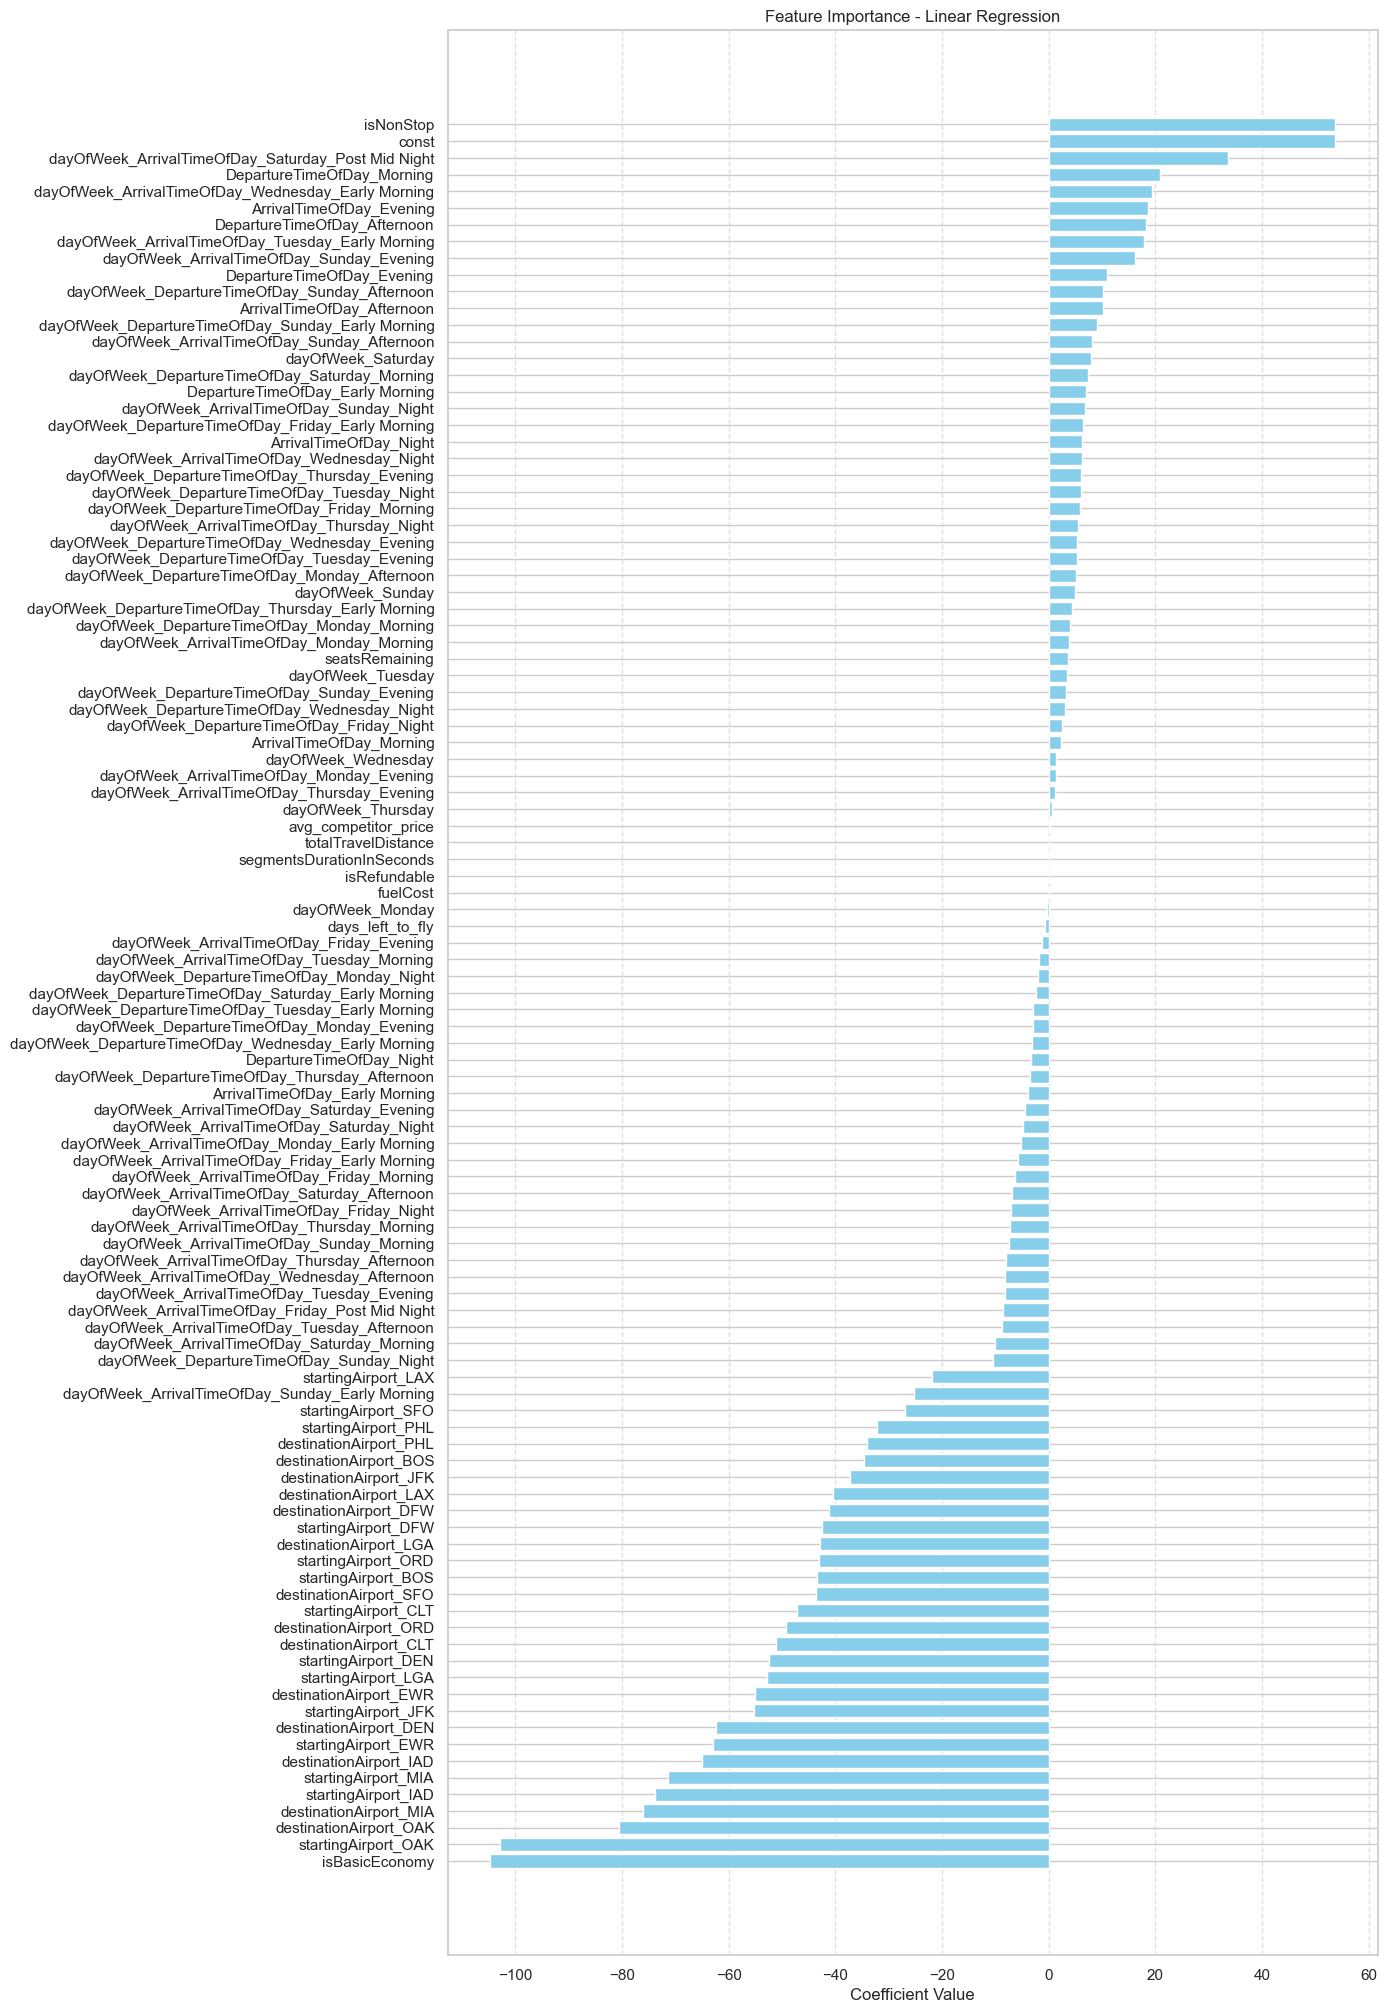

In [56]:
# Extract coefficients of significant variables
coefficients = significant_model.params.loc[significant_vars]

# Sort coefficients and variable names based on their values
sorted_coefficients = coefficients.sort_values(ascending=True)
sorted_variables = sorted_coefficients.index

# Plot the horizontal bar graph with a larger figure size
plt.figure(figsize=(12, 25))
plt.barh(sorted_variables, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance - Linear Regression')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

<a id="eval1"></a>
<h3 name='eval1'>   
      <font color = purple >
            <span style='font-family:Georgia'>
            Model Evaluation
            </span>   
        </font>    
</h3>

<a id="norm"></a>
<h5 name='norm'>   
      <font color = black >
            <span style='font-family:Georgia'>
            Perform Model Diagnostics: Normality of Residuals
            </span>   
        </font>    
</h5>

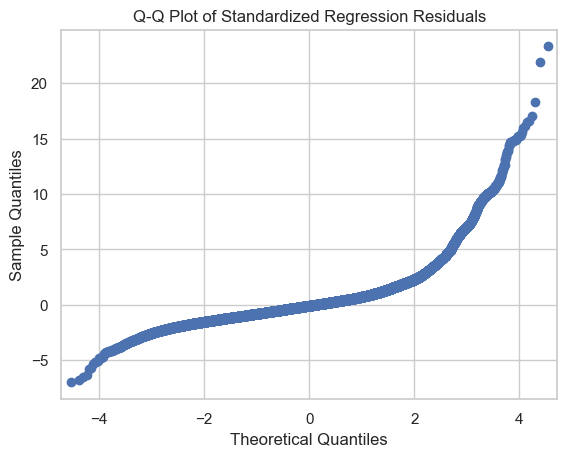

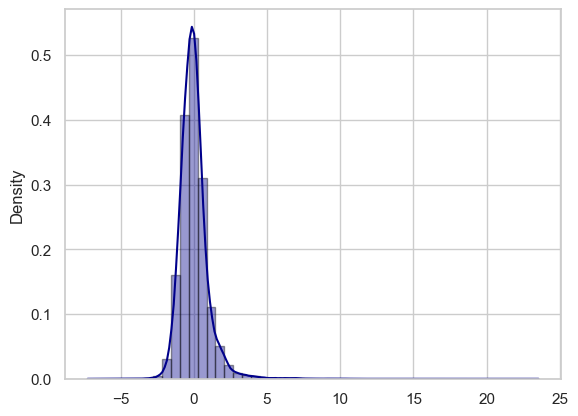

In [57]:
# Standardization function
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

# Gathering residuals and standardizing them
resid = significant_model.resid
resid_std =get_standardized_values(resid)

# QQ plot
sm.qqplot(resid_std) 
plt.title( "Q-Q Plot of Standardized Regression Residuals" );
plt.show()

# Density Plot
sn.distplot(resid_std, color = 'darkblue',hist_kws={'edgecolor':'black'});

# Both QQ Plot and Distribution Plot show that residuals are approximately normally distributed 

<a id="homo"></a>
<h5 name='homo'>   
      <font color = black >
            <span style='font-family:Georgia'>
            Perform Model Diagnostics: Homoscedasticity of residuals
            </span>   
        </font>    
</h5>

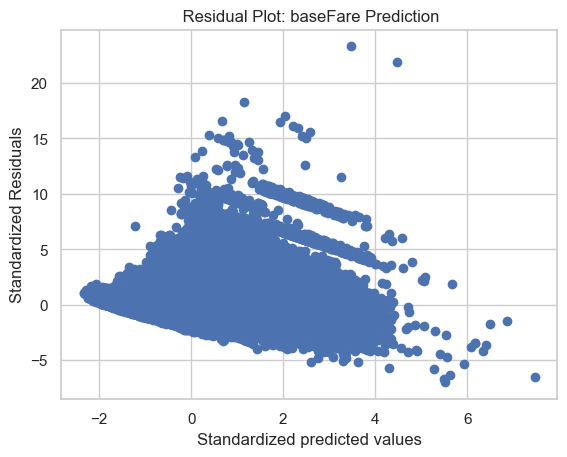

In [58]:
fittedvalues_std = get_standardized_values( significant_model.fittedvalues )
plt.scatter( fittedvalues_std, resid_std)
plt.title( " Residual Plot: baseFare Prediction" );
plt.xlabel( "Standardized predicted values")
plt.ylabel( "Standardized Residuals");

# Plot shows that residuals are random and doesnot show any pattern. So residuals are homoscedastic

<a id="eval1"></a>
<h5 name='eval1'>   
      <font color = black >
            <span style='font-family:Georgia'>
            Influencer Analysis
            </span>   
        </font>    
</h5>

values and indices [] (array([], dtype=int64),)


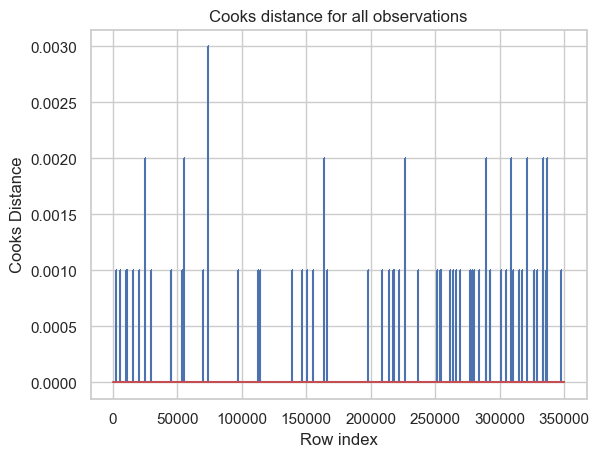

In [59]:
# Cook's Distance
model_influence = significant_model.get_influence()
(c, p) = model_influence.cooks_distance
plt.stem( np.arange( len( train_X) ), np.round( c, 3 ), markerfmt="," );
plt.title( "Cooks distance for all observations" );
plt.xlabel( "Row index")
plt.ylabel( "Cooks Distance");
print("values and indices",c[c>1.0],np.nonzero(c>1.0))

# No influential variables as per Cooks Distance as none of the variables have a cook's distance greater than 1 and A Cook's distance value of > 1 indicates highly influential observation.

<a id="val"></a>
<h5 name='val'>   
      <font color = black >
            <span style='font-family:Georgia'>
            Measure model accuracy and validate model
            </span>   
        </font>    
</h5>

In [60]:
pred_y = significant_model.predict( test_X[train_X.columns] )

rsquare_train = round(r2_score(train_y, significant_model.fittedvalues),4)
rsquare_valid = round(r2_score(test_y, pred_y),4)

rmse_train = round(np.sqrt(mean_squared_error(train_y,significant_model.fittedvalues)),4)
rmse_valid = round(np.sqrt(mean_squared_error(test_y,pred_y)),4)

print("R-Square_Train: ", rsquare_train, " RMSE_Train: ", rmse_train)
print("R-Square_Valid: ", rsquare_valid, " RMSE_Valid: ", rmse_valid)

R-Square_Train:  0.6708  RMSE_Train:  73.9167
R-Square_Valid:  0.6707  RMSE_Valid:  73.7483


<a id="pred"></a>
<h5 name='pred'>   
      <font color = black >
            <span style='font-family:Georgia'>
            Making Predictions
            </span>   
        </font>    
</h5>

In [61]:
# Calculating Prediction Intervals

predictions = significant_model.get_prediction(test_X[train_X.columns])
predictions_df = round(predictions.summary_frame(alpha=0.05),2)
predictions_df

# Store all the values in a dataframe
pred_y_df = pd.DataFrame( { 'test_y': test_y,
                            'pred_y': predictions_df['mean'],
                            'pred_y_left': predictions_df['obs_ci_lower'],
                            'pred_y_right': predictions_df['obs_ci_upper'],
                            'pred_interval_size':predictions_df['obs_ci_upper']-predictions_df['obs_ci_lower']} )
pred_y_df

test_y  pred_y  pred_y_left  pred_y_right  pred_interval_size
2798134   96.74  113.50       -31.41        258.42              289.83
2917232  180.47  200.65        55.74        345.56              289.82
4302194  143.26  181.99        37.08        326.91              289.83
1236752  282.79  155.97        11.06        300.88              289.82
855440   256.74  255.90       110.99        400.82              289.83
...         ...     ...          ...           ...                 ...
1890714  189.77  235.10        90.20        380.01              289.81
924412   203.72  161.86        16.94        306.78              289.84
2935471  199.07  255.48       110.57        400.40              289.83
431950   203.72  243.03        98.11        387.95              289.84
1667333   92.09   99.23       -45.68        244.15              289.83

[150000 rows x 5 columns]

In [62]:
# Calculate the difference between test_y and pred_y
pred_y_df['residuals'] = pred_y_df['test_y'] - pred_y_df['pred_y']

# Find the mean of the residuals
mean_residuals = pred_y_df['residuals'].mean()

# Print the updated dataframe and the mean of residuals
print(pred_y_df)
print("\nMean of Residuals:", mean_residuals)


         test_y  pred_y  pred_y_left  pred_y_right  pred_interval_size  \
2798134   96.74  113.50       -31.41        258.42              289.83   
2917232  180.47  200.65        55.74        345.56              289.82   
4302194  143.26  181.99        37.08        326.91              289.83   
1236752  282.79  155.97        11.06        300.88              289.82   
855440   256.74  255.90       110.99        400.82              289.83   
...         ...     ...          ...           ...                 ...   
1890714  189.77  235.10        90.20        380.01              289.81   
924412   203.72  161.86        16.94        306.78              289.84   
2935471  199.07  255.48       110.57        400.40              289.83   
431950   203.72  243.03        98.11        387.95              289.84   
1667333   92.09   99.23       -45.68        244.15              289.83   

         residuals  
2798134     -16.76  
2917232     -20.18  
4302194     -38.73  
1236752     126.82  
855440

In [63]:
# Perform paired t-test
t_statistic, p_value = ttest_rel(pred_y_df['test_y'], pred_y_df['pred_y'])

# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

Paired t-test results:
t-statistic: -1.4017092100123423
p-value: 0.16100416840126142


In [64]:
itineraries_df.to_csv('preprocessed_data.csv', index=False)

<a id="learn"></a>
<div class="alert alert-block alert-info">
    <span style='font-family:Garamound'>
        <b>Post Evaluation, the following results can be concluded:</b>
        <ol>
            <li><b>Accuracy:</b> 0.73 or 73%</li>
            <li><b>Precision:</b> 0.824</li>
            <li><b>AUC:</b> 0.82</li>
        </ol>
    </span> 
</div>